# 🩺 Milestone 1: Data Ingestion & Parameter Interpretation
Medical intelligence begins not with prediction, but with interpretation. Blood reports, though rich in clinical meaning, are rarely uniform in structure. They appear as machine-generated PDFs, scanned paper records, or semi-structured digital files, each shaped by laboratory-specific conventions. Milestone 1 focuses on building the system’s capacity to reliably ingest such heterogeneous medical documents and extract clinically meaningful parameters with high fidelity.

### Disease Categorization Based on Medical Literature

After an extensive review of peer-reviewed journals, institutional clinical guidelines, and publicly available medical datasets, diseases identifiable through blood analysis were classified into eight broad clinical categories. This categorization reflects how clinicians naturally reason about laboratory data across physiological systems and serves as the conceptual foundation for parameter interpretation.

1. **Blood & Hematological Disorders**
2. **Metabolic & Endocrine Disorders**
3. **Liver & Gallbladder Diseases**
4. **Kidney & Urinary Disorders**
5. **Cardiovascular & Vascular Conditions**
6. **Infections & Immune Conditions**
7. **Autoimmune & Inflammatory Diseases**
8. **Nutritional Deficiencies & Toxicities**

These categories do not represent diagnostic labels, but rather analytical domains within which blood parameters acquire clinical meaning.

### Data Ingestion and Extraction Approach

The system implements an input interface capable of handling multiple report formats, including structured data files, digital PDFs, and scanned images. For non-textual or semi-textual inputs, optical character recognition is employed to extract textual content. The extraction engine identifies clinically relevant parameters, their corresponding values, and measurement units, while remaining robust to variations in report layout, terminology, and formatting commonly observed across Indian diagnostic laboratories.

### Validation, Standardization, and Parameter Interpretation

Extracted values are passed through a validation and standardization layer where units are normalized, missing or implausible values are detected, and inconsistencies are resolved where possible. This step ensures that downstream analysis is based on medically coherent data rather than raw textual output.

At the core of this milestone lies **Model 1: Parameter Interpretation**. Each laboratory parameter is evaluated independently against standard medical reference ranges derived from clinical literature. The model classifies values as *low*, *normal*, or *high*, mirroring the initial interpretive step performed by clinicians when reviewing laboratory reports. At this stage, no cross-parameter reasoning or disease inference is attempted; the objective is accuracy and clinical correctness at the individual parameter level.

### Evaluation Strategy

The effectiveness of Milestone 1 is assessed using a curated set of diverse blood reports obtained from multiple laboratory formats. Extracted values are manually verified against source documents, and classification results are compared with established medical reference ranges. Success at this stage is defined by high accuracy in both data extraction and parameter-level classification, ensuring that subsequent analytical models operate on a reliable foundation.

### Reference Datasets and Clinical Sources

This milestone is informed by established medical datasets and authoritative clinical resources, including:

* Abdul-Jabbar, Safa S.; Farhan, Dr. Alaa (2022). *Hematological Dataset*. Mendeley Data, V1. DOI: **10.17632/g7kf8x38ym.1**
* Turki, Amina et al. (2024). *Gallbladder Diseases Dataset*. Mendeley Data, V2. DOI: **10.17632/r6h24d2d3y.2**
* UK Kidney Association clinical datasets and staging guidelines
* Oxford Academic and Oxford Medicine Online clinical references


In [37]:
import os
import re
import pandas as pd
import pytesseract
from pdf2image import convert_from_path
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed

### 📂 Define Dataset Paths

In [38]:
BASE_DATA_PATH = "data"

DATASET_DIRS = [
    d for d in os.listdir(BASE_DATA_PATH)
    if os.path.isdir(os.path.join(BASE_DATA_PATH, d))
]

DATASET_DIRS


['liver_gallbladder_dataset',
 'autoimmune_inflammatory_dataset',
 'hematology_dataset',
 'infections_immune_dataset',
 'kidney_urinary_dataset',
 'cardiovascular_dataset',
 'metabolic_endocrine_dataset']

### 🧠 OCR Extraction Helpers

In [39]:
#PDF → text
def extract_text_from_pdf(pdf_path):
    text = ""
    pages = convert_from_path(pdf_path, dpi=300)
    for page in pages:
        text += pytesseract.image_to_string(page)
    return text
#Image → text
def extract_text_from_image(img_path):
    image = Image.open(img_path)
    return pytesseract.image_to_string(image)


### 🧬 Generic Parameter Parser (Extendable)

In [40]:
def parse_parameters(text):
    extracted = {}

    patterns = {
        "Patient_ID": r"Patient\s*ID\s*[:\-]?\s*(\w+)",
        "Age": r"Age\s*[:\-]?\s*(\d+)",
        "Gender": r"(Male|Female)",
        "Hemoglobin_g_dL": r"Hemoglobin\s*[:\-]?\s*([\d.]+)",
        "CRP_mg_L": r"CRP\s*[:\-]?\s*([\d.]+)",
        "ESR_mm_hr": r"ESR\s*[:\-]?\s*([\d.]+)",
        "LDL_mg_dL": r"LDL\s*[:\-]?\s*([\d.]+)",
        "HDL_mg_dL": r"HDL\s*[:\-]?\s*([\d.]+)",
        "Triglycerides_mg_dL": r"Triglycerides\s*[:\-]?\s*([\d.]+)",
        "Creatinine_mg_dL": r"Creatinine\s*[:\-]?\s*([\d.]+)",
    }

    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        extracted[key] = match.group(1) if match else None

    return extracted


### 📄 Read One Dataset (PDF + Image)

In [41]:
def read_single_dataset(dataset_path):
    rows = []

    pdf_dir = os.path.join(dataset_path, "pdf_reports")
    img_dir = os.path.join(dataset_path, "image_reports")

    # ---- PDFs ----
    if os.path.exists(pdf_dir):
        for file in os.listdir(pdf_dir):
            if file.endswith(".pdf"):
                path = os.path.join(pdf_dir, file)
                text = extract_text_from_pdf(path)
                row = parse_parameters(text)
                row["Report_Name"] = file
                row["Report_Format"] = "PDF"
                row["Dataset"] = os.path.basename(dataset_path)
                rows.append(row)

    # ---- Images ----
    if os.path.exists(img_dir):
        for file in os.listdir(img_dir):
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                path = os.path.join(img_dir, file)
                text = extract_text_from_image(path)
                row = parse_parameters(text)
                row["Report_Name"] = file
                row["Report_Format"] = "Scanned Image"
                row["Dataset"] = os.path.basename(dataset_path)
                rows.append(row)

    return pd.DataFrame(rows)


### 🔗 Load ALL DATASETS into One DataFrame (In-Memory)

In [ ]:
def load_dataset(dataset):
    dataset_path = os.path.join(BASE_DATA_PATH, dataset)
    df = read_single_dataset(dataset_path)
    return dataset, df


dataset_dfs = {}

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [
        executor.submit(load_dataset, dataset)
        for dataset in DATASET_DIRS
    ]

    for future in as_completed(futures):
        dataset_name, df = future.result()
        dataset_dfs[dataset_name] = df


In [44]:
for name, df in dataset_dfs.items():
    print(f"\n{name} — first 10 rows")
    display(df.head(10))



kidney_urinary_dataset — first 10 rows


,Patient_ID,Patient_Name,Age,Gender,Serum_Creatinine_mg_dL,Blood_Urea_mg_dL,BUN_mg_dL,eGFR_mL_min_1_73m2,Uric_Acid_mg_dL,Sodium_mEq_L,...,Dialysis_Status,Diabetes_Duration_years,NSAID_Use,ACE_Inhibitor_Use,Kidney_Ultrasound,Provisional_Diagnosis,Lab_Name,Test_City,Report_Format,Sample_Type
0,IND_KID_0001,Ritu Banerjee,74,Female,7.44,146.27,95.82,7.21,10.22,138.99,...,Hemodialysis,18,No,No,Normal,Renal Failure,Thyrocare,Delhi,Scanned Image,Venous Blood
1,IND_KID_0002,Suman Roy,32,Female,3.13,26.42,6.44,23.21,4.01,132.81,...,Hemodialysis,1,No,Yes,Small Kidneys,Diabetic Nephropathy,Apollo Diagnostics,Hyderabad,Scanned Image,Venous Blood
2,IND_KID_0003,Pankaj Mondal,23,Female,3.99,75.77,43.72,18.75,6.08,130.71,...,No,15,No,Yes,Small Kidneys,Uremia,Metropolis,Bengaluru,PDF,Venous Blood
3,IND_KID_0004,Ravi Kumar,25,Female,7.82,64.17,54.90,8.48,10.58,152.26,...,Hemodialysis,25,No,No,Increased Echogenicity,Uremia,Apollo Diagnostics,Hyderabad,Scanned Image,Venous Blood
4,IND_KID_0005,Deepak Yadav,61,Male,7.93,128.34,45.11,6.96,9.94,127.68,...,Peritoneal,15,No,No,Normal,Uremia,SRL Diagnostics,Bengaluru,Scanned Image,Venous Blood
5,IND_KID_0006,Sourav Das,57,Male,2.28,176.64,55.53,29.75,11.32,129.71,...,Hemodialysis,20,Yes,No,Normal,Normal,Dr Lal PathLabs,Chennai,Scanned Image,Venous Blood
6,IND_KID_0007,Sneha Kulkarni,81,Female,4.43,127.55,16.21,12.87,4.53,134.71,...,Peritoneal,22,No,No,Increased Echogenicity,Renal Failure,Apollo Diagnostics,Chennai,PDF,Venous Blood
7,IND_KID_0008,Nikhil Mehta,71,Male,5.46,70.72,59.36,10.39,8.66,132.63,...,Peritoneal,13,Yes,No,Normal,Normal,Metropolis,Kolkata,Scanned Image,Venous Blood
8,IND_KID_0009,Deepak Yadav,38,Female,5.63,33.67,82.08,11.38,5.15,148.38,...,Peritoneal,4,Yes,Yes,Small Kidneys,Electrolyte Imbalance,Metropolis,Chennai,PDF,Venous Blood
9,IND_KID_0010,Nikhil Mehta,33,Male,2.24,32.57,17.62,33.93,11.73,134.57,...,No,18,No,No,Small Kidneys,Normal,Thyrocare,Chennai,Scanned Image,Venous Blood



indian_metabolic_endocrine_dataset — first 10 rows


,Patient_ID,Patient_Name,Age,Gender,BMI,Waist_Circumference_cm,Fasting_Glucose_mg_dL,Postprandial_Glucose_mg_dL,HbA1c_percent,Fasting_Insulin_uIU_mL,...,Physical_Activity_Level,Smoking_Status,Alcohol_Consumption,Family_History_Diabetes,Family_History_Thyroid,Provisional_Diagnosis,Lab_Name,Test_City,Report_Format,Sample_Type
0,IND_MET_0001,Vikram Rao,73,Female,31.09,104.82,108.15,349.05,11.36,10.42,...,High,Non-smoker,Regular,Yes,Yes,Hyperthyroidism,SRL Diagnostics,Hyderabad,PDF,Venous Blood
1,IND_MET_0002,Kavita Nair,67,Female,24.96,104.01,214.45,162.28,7.14,15.59,...,High,Non-smoker,Regular,Yes,Yes,Hypothyroidism,Metropolis,Delhi,PDF,Venous Blood
2,IND_MET_0003,Deepak Yadav,68,Male,19.54,111.73,67.06,290.31,6.20,21.23,...,Low,Non-smoker,No,No,No,Prediabetes,SRL Diagnostics,Mumbai,Scanned Image,Venous Blood
3,IND_MET_0004,Anjali Iyer,68,Female,24.16,84.36,74.33,275.45,5.75,22.54,...,High,Non-smoker,Regular,No,Yes,Type 2 Diabetes,Thyrocare,Kolkata,Scanned Image,Venous Blood
4,IND_MET_0005,Sneha Kulkarni,34,Female,31.91,72.38,196.63,144.32,6.01,32.81,...,High,Non-smoker,Occasional,Yes,Yes,Dyslipidemia,Thyrocare,Bengaluru,Scanned Image,Venous Blood
5,IND_MET_0006,Rohit Agarwal,69,Female,33.74,72.84,135.05,153.01,11.44,21.75,...,Moderate,Smoker,Occasional,Yes,Yes,Hyperthyroidism,Apollo Diagnostics,Delhi,PDF,Venous Blood
6,IND_MET_0007,Neha Patel,44,Female,36.24,107.90,190.97,345.63,5.25,29.47,...,High,Smoker,Occasional,No,No,Dyslipidemia,SRL Diagnostics,Mumbai,PDF,Venous Blood
7,IND_MET_0008,Manish Pandey,63,Male,25.76,79.64,163.84,276.88,7.17,32.60,...,High,Smoker,Regular,Yes,No,Prediabetes,Metropolis,Kolkata,PDF,Venous Blood
8,IND_MET_0009,Suman Roy,22,Male,17.97,116.58,151.87,198.22,5.84,18.89,...,Moderate,Smoker,No,Yes,Yes,Metabolic Syndrome,SRL Diagnostics,Bengaluru,Scanned Image,Venous Blood
9,IND_MET_0010,Deepak Yadav,52,Female,24.99,84.59,197.54,193.10,5.18,9.43,...,Low,Non-smoker,Regular,No,Yes,Type 2 Diabetes,SRL Diagnostics,Chennai,PDF,Venous Blood



liver_gallbladder_dataset — first 10 rows


,Patient_ID,Patient_Name,Age,Gender,BMI,Alcohol_Consumption,ALT_U_L,AST_U_L,AST_ALT_Ratio,ALP_U_L,...,Drug_History,Ascites_Present,Hepatic_Encephalopathy,Fatty_Liver_Grade,Ultrasound_Impression,Provisional_Diagnosis,Lab_Name,Test_City,Report_Format,Sample_Type
0,IND_LIV_0001,Suman Roy,41,Female,21.16,Heavy,292,85,1.80,532,...,No,Yes,No,Grade 1,Fatty Liver,Alcoholic Liver Disease,SRL Diagnostics,Delhi,Scanned Image,Venous Blood
1,IND_LIV_0002,Sneha Kulkarni,30,Female,17.21,No,232,102,2.52,60,...,Yes,Yes,No,Grade 3,Normal Liver,NAFLD,SRL Diagnostics,Mumbai,PDF,Venous Blood
2,IND_LIV_0003,Amit Sharma,19,Male,26.84,No,289,133,3.03,105,...,Yes,Yes,No,NaN,Fatty Liver,Jaundice,Dr Lal PathLabs,Bengaluru,Scanned Image,Venous Blood
3,IND_LIV_0004,Kavita Nair,25,Male,28.37,Regular,327,495,2.03,216,...,Yes,No,No,Grade 3,Normal Liver,Drug-induced Liver Injury,Apollo Diagnostics,Bengaluru,PDF,Venous Blood
4,IND_LIV_0005,Vikram Rao,80,Female,20.60,Heavy,85,258,3.33,89,...,No,No,No,Grade 2,Cirrhotic Liver,Liver Cirrhosis,SRL Diagnostics,Chennai,PDF,Venous Blood
5,IND_LIV_0006,Rahul Verma,25,Female,18.52,Heavy,321,40,3.00,74,...,No,No,No,Grade 1,Hepatomegaly,Liver Cirrhosis,Apollo Diagnostics,Delhi,Scanned Image,Venous Blood
6,IND_LIV_0007,Ravi Kumar,43,Male,34.10,Regular,299,118,3.08,582,...,No,Yes,No,Grade 2,Cholestasis,Drug-induced Liver Injury,Dr Lal PathLabs,Chennai,Scanned Image,Venous Blood
7,IND_LIV_0008,Ankit Gupta,25,Female,25.59,Occasional,38,172,1.81,432,...,Yes,Yes,No,NaN,Normal Liver,Alcoholic Liver Disease,SRL Diagnostics,Kolkata,PDF,Venous Blood
8,IND_LIV_0009,Amit Sharma,22,Female,26.31,Occasional,193,163,1.26,192,...,No,Yes,No,Grade 3,Normal Liver,Normal,Dr Lal PathLabs,Chennai,PDF,Venous Blood
9,IND_LIV_0010,Manish Pandey,75,Male,21.82,Regular,404,66,2.94,125,...,No,No,No,Grade 1,Cholestasis,Drug-induced Liver Injury,Metropolis,Hyderabad,Scanned Image,Venous Blood



cardiovascular_dataset — first 10 rows


,Patient_ID,Patient_Name,Age,Gender,Height_cm,Weight_kg,BMI,Waist_Circumference_cm,Systolic_BP_mmHg,Diastolic_BP_mmHg,...,Family_History_CVD,Diabetes_Status,Hypertension_Treatment,Statin_Use,ECG_Impression,Provisional_Diagnosis,Lab_Name,Test_City,Report_Format,Sample_Type
0,IND_CARD_0001,Deepak Yadav,49,Female,165.08,89.90,19.90,74.05,100,108,...,Yes,Prediabetes,No,Yes,Arrhythmia Suspected,Heart Attack Risk,Apollo Diagnostics,Kolkata,PDF,Venous Blood
1,IND_CARD_0002,Rahul Verma,48,Female,171.83,87.28,26.48,69.09,136,83,...,Yes,Prediabetes,No,Yes,Arrhythmia Suspected,High LDL Syndrome,Apollo Diagnostics,Delhi,Scanned Image,Venous Blood
2,IND_CARD_0003,Arjun Malhotra,53,Female,188.06,97.50,28.50,90.12,188,62,...,Yes,Prediabetes,No,Yes,Normal,Atherosclerosis,Metropolis,Bengaluru,PDF,Venous Blood
3,IND_CARD_0004,Vikram Rao,73,Female,168.99,93.30,29.31,70.86,114,77,...,No,Diabetes,No,No,ST Changes,Heart Attack Risk,Metropolis,Bengaluru,Scanned Image,Venous Blood
4,IND_CARD_0005,Sourav Das,45,Male,184.99,101.04,21.76,64.84,100,77,...,No,Prediabetes,Yes,Yes,Normal,Coronary Artery Disease Risk,SRL Diagnostics,Mumbai,Scanned Image,Venous Blood
5,IND_CARD_0006,Ritu Banerjee,66,Female,189.62,47.23,18.96,100.73,138,71,...,No,No,Yes,No,ST Changes,High LDL Syndrome,Apollo Diagnostics,Delhi,PDF,Venous Blood
6,IND_CARD_0007,Vikram Rao,32,Female,189.62,100.10,19.18,118.67,185,68,...,Yes,Diabetes,Yes,No,LVH,Hypercholesterolemia,Metropolis,Hyderabad,Scanned Image,Venous Blood
7,IND_CARD_0008,Deepak Yadav,60,Female,182.58,64.32,35.06,112.15,113,108,...,Yes,Prediabetes,No,No,LVH,High LDL Syndrome,Thyrocare,Delhi,PDF,Venous Blood
8,IND_CARD_0009,Manish Pandey,31,Male,181.87,94.26,29.40,66.18,97,79,...,Yes,Diabetes,No,No,Normal,Atherosclerosis,Thyrocare,Mumbai,PDF,Venous Blood
9,IND_CARD_0010,Ravi Kumar,62,Male,155.57,53.62,17.78,71.25,114,100,...,No,Prediabetes,Yes,Yes,Normal,Atherosclerosis,Thyrocare,Chennai,Scanned Image,Venous Blood



hematology_dataset — first 10 rows


,Patient_ID,Patient_Name,Age,Gender,Hemoglobin_g_dL,RBC_million_uL,WBC_cells_uL,Platelets_lakh_uL,Hematocrit_percent,MCV_fL,...,Peripheral_Smear_Result,Sickle_Cell_Test,Hb_Electrophoresis_Result,Bone_Marrow_Suspicion,Provisional_Diagnosis,Lab_Name,Test_City,Report_Format,Fasting_Status,Sample_Type
0,IND0001,Rohit Agarwal,57,Female,17.43,4.38,7293,4.62,48.06,82.37,...,Microcytic,Negative,Sickle Cell Trait,Yes,Iron Deficiency Anemia,Dr Lal PathLabs,Bengaluru,Scanned Image,No,Venous Blood
1,IND0002,Ankit Gupta,18,Male,12.75,4.05,11678,1.60,37.55,87.52,...,Normal,Positive,Beta Thalassemia Trait,No,Pancytopenia,Apollo Diagnostics,Delhi,Scanned Image,Yes,Venous Blood
2,IND0003,Ankit Gupta,54,Female,17.01,4.63,9132,4.80,31.65,89.76,...,Anisocytosis,Negative,Normal,Yes,Vitamin B12 Deficiency,Apollo Diagnostics,Hyderabad,Scanned Image,No,Venous Blood
3,IND0004,Arjun Malhotra,48,Male,12.88,5.55,5236,2.50,44.96,79.49,...,Macrocytic,Negative,Sickle Cell Trait,Yes,Vitamin B12 Deficiency,Dr Lal PathLabs,Delhi,PDF,No,Venous Blood
4,IND0005,Deepak Yadav,37,Male,12.03,3.95,11356,3.74,37.84,84.18,...,Macrocytic,Negative,Beta Thalassemia Trait,Yes,Vitamin B12 Deficiency,SRL Diagnostics,Hyderabad,PDF,Yes,Venous Blood
5,IND0006,Nikhil Mehta,55,Male,11.97,5.72,7687,3.72,38.75,71.63,...,Hypochromic,Negative,Sickle Cell Trait,Yes,Leukemia Suspected,Dr Lal PathLabs,Hyderabad,PDF,No,Venous Blood
6,IND0007,Nikhil Mehta,49,Female,13.24,5.41,9356,4.69,35.88,66.26,...,Anisocytosis,Positive,Beta Thalassemia Trait,No,Vitamin B12 Deficiency,Thyrocare,Mumbai,PDF,Yes,Venous Blood
7,IND0008,Nikhil Mehta,37,Female,16.12,5.67,6878,2.83,38.81,93.83,...,Hypochromic,Positive,Beta Thalassemia Trait,No,Iron Deficiency Anemia,Thyrocare,Chennai,PDF,Yes,Venous Blood
8,IND0009,Priya Singh,57,Male,14.95,5.45,10736,4.40,37.29,62.40,...,Hypochromic,Negative,Normal,Yes,Vitamin B12 Deficiency,Dr Lal PathLabs,Mumbai,PDF,No,Venous Blood
9,IND0010,Ritu Banerjee,43,Male,12.00,4.54,9716,3.42,35.93,99.34,...,Hypochromic,Positive,Beta Thalassemia Trait,Yes,Vitamin B12 Deficiency,Apollo Diagnostics,Kolkata,Scanned Image,Yes,Venous Blood



infections_immune_dataset — first 10 rows


,Patient_ID,Patient_Name,Age,Gender,Body_Temperature_C,Pulse_Rate_bpm,Respiratory_Rate_per_min,Systolic_BP_mmHg,Diastolic_BP_mmHg,WBC_cells_uL,...,Blood_Culture_Result,Oxygen_Saturation_percent,Chest_Xray_Impression,Hospitalization_Required,ICU_Admission,Provisional_Diagnosis,Lab_Name,Test_City,Report_Format,Sample_Type
0,IND_INF_0001,Kavita Nair,9,Female,36.65,125,16,138,74,2361,...,Gram Negative Bacteria,98.37,Consolidation,No,No,Dengue,Dr Lal PathLabs,Mumbai,Scanned Image,Venous Blood
1,IND_INF_0002,Amit Sharma,48,Male,39.43,96,32,86,65,3498,...,Gram Positive Bacteria,87.37,Consolidation,Yes,Yes,Typhoid,SRL Diagnostics,Kolkata,Scanned Image,Venous Blood
2,IND_INF_0003,Manish Pandey,84,Female,38.32,71,39,85,82,16973,...,No Growth,87.27,Normal,No,Yes,Malaria,Metropolis,Mumbai,Scanned Image,Venous Blood
3,IND_INF_0004,Pankaj Mondal,30,Female,39.10,65,28,100,71,23867,...,No Growth,99.91,Consolidation,Yes,No,Normal,Thyrocare,Hyderabad,Scanned Image,Venous Blood
4,IND_INF_0005,Priya Singh,73,Female,36.40,62,34,114,92,14571,...,Gram Positive Bacteria,96.52,Consolidation,No,No,Sepsis,Dr Lal PathLabs,Kolkata,PDF,Venous Blood
5,IND_INF_0006,Manish Pandey,13,Female,40.53,86,28,115,84,19548,...,Gram Positive Bacteria,98.11,Normal,Yes,Yes,HIV Screening,Dr Lal PathLabs,Mumbai,PDF,Venous Blood
6,IND_INF_0007,Pankaj Mondal,74,Female,40.82,140,13,81,65,20225,...,No Growth,93.29,Consolidation,Yes,Yes,Normal,Metropolis,Chennai,PDF,Venous Blood
7,IND_INF_0008,Kavita Nair,81,Female,40.50,116,28,102,76,24499,...,Gram Negative Bacteria,99.52,Ground Glass Opacity,No,No,Normal,Apollo Diagnostics,Mumbai,Scanned Image,Venous Blood
8,IND_INF_0009,Rohit Agarwal,5,Male,36.42,84,18,149,68,11174,...,No Growth,85.23,Normal,No,Yes,Normal,Apollo Diagnostics,Delhi,Scanned Image,Venous Blood
9,IND_INF_0010,Nikhil Mehta,33,Female,36.45,96,23,111,80,3676,...,Gram Positive Bacteria,88.00,Ground Glass Opacity,No,Yes,Malaria,Thyrocare,Bengaluru,Scanned Image,Venous Blood



autoimmune_inflammatory_dataset — first 10 rows


,Patient_ID,Patient_Name,Age,Gender,ESR_mm_hr,CRP_mg_L,Rheumatoid_Factor_IU_mL,Anti_CCP_U_mL,ANA_Titer,Anti_dsDNA_IU_mL,...,Skin_Rash,Photosensitivity,Diarrhea,Weight_Loss,Family_History_Autoimmune,Provisional_Diagnosis,Lab_Name,Test_City,Report_Format,Sample_Type
0,IND_AUTO_0001,Deepak Yadav,57,Male,37,9.57,108.52,256.53,1:160,626.72,...,No,Yes,Yes,Yes,Yes,Rheumatoid Arthritis,Thyrocare,Kolkata,PDF,Venous Blood
1,IND_AUTO_0002,Amit Sharma,57,Male,22,1.91,194.50,128.32,1:80,130.21,...,No,Yes,No,Yes,No,Celiac Disease,Dr Lal PathLabs,Hyderabad,Scanned Image,Venous Blood
2,IND_AUTO_0003,Suman Roy,38,Female,65,49.49,184.38,176.01,1:80,413.98,...,Yes,No,No,No,Yes,Rheumatoid Arthritis,Dr Lal PathLabs,Kolkata,Scanned Image,Venous Blood
3,IND_AUTO_0004,Neha Patel,79,Male,96,87.52,469.48,51.57,1:320,519.08,...,No,Yes,Yes,No,No,Normal,Thyrocare,Delhi,Scanned Image,Venous Blood
4,IND_AUTO_0005,Anjali Iyer,62,Female,27,70.28,21.82,252.98,1:160,224.85,...,Yes,Yes,Yes,Yes,Yes,Chronic Inflammation,Thyrocare,Chennai,Scanned Image,Venous Blood
5,IND_AUTO_0006,Sourav Das,46,Female,27,25.28,61.14,122.84,1:320,41.00,...,Yes,Yes,No,Yes,No,Normal,SRL Diagnostics,Bengaluru,Scanned Image,Venous Blood
6,IND_AUTO_0007,Ankit Gupta,47,Female,82,2.60,20.78,233.93,1:80,160.10,...,Yes,Yes,Yes,No,Yes,Rheumatoid Arthritis,Dr Lal PathLabs,Mumbai,Scanned Image,Venous Blood
7,IND_AUTO_0008,Nikhil Mehta,75,Male,30,17.73,64.63,15.59,1:320,150.11,...,Yes,Yes,No,No,No,Rheumatoid Arthritis,Dr Lal PathLabs,Kolkata,Scanned Image,Venous Blood
8,IND_AUTO_0009,Nikhil Mehta,73,Male,88,60.29,240.90,153.86,Negative,746.10,...,No,No,No,Yes,Yes,Systemic Lupus Erythematosus,Metropolis,Kolkata,Scanned Image,Venous Blood
9,IND_AUTO_0010,Vikram Rao,45,Female,34,65.59,112.11,236.91,1:80,165.78,...,Yes,Yes,No,Yes,No,Normal,SRL Diagnostics,Delhi,PDF,Venous Blood


### Shape & Missing Values Summary

In [45]:
summary = []

for name, df in dataset_dfs.items():
    summary.append({
        "Dataset": name,
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Total Missing Values": df.isna().sum().sum()
    })

pd.DataFrame(summary)


,Dataset,Rows,Columns,Total Missing Values
0,kidney_urinary_dataset,100,39,0
1,indian_metabolic_endocrine_dataset,100,43,0
2,liver_gallbladder_dataset,100,39,30
3,cardiovascular_dataset,100,41,0
4,hematology_dataset,100,40,0
5,infections_immune_dataset,100,45,0
6,autoimmune_inflammatory_dataset,100,39,0


### 🧪 Column Presence Heatmap (Textual)

In [46]:
for name, df in dataset_dfs.items():
    print(f"\n{name}")
    print(df.notna().sum().sort_values(ascending=False))



kidney_urinary_dataset
Patient_ID                       100
Patient_Name                     100
Age                              100
Gender                           100
Serum_Creatinine_mg_dL           100
Blood_Urea_mg_dL                 100
BUN_mg_dL                        100
eGFR_mL_min_1_73m2               100
Uric_Acid_mg_dL                  100
Sodium_mEq_L                     100
Potassium_mEq_L                  100
Chloride_mEq_L                   100
Calcium_mg_dL                    100
Phosphorus_mg_dL                 100
Magnesium_mg_dL                  100
Bicarbonate_mEq_L                100
Fasting_Glucose_mg_dL            100
HbA1c_percent                    100
Urine_Albumin_mg_L               100
Urine_Creatinine_mg_dL           100
Albumin_Creatinine_Ratio         100
Urinalysis_Protein               100
Urinalysis_Glucose               100
Urinalysis_RBC                   100
Urinalysis_WBC                   100
Specific_Gravity                 100
Blood_Pressure

### 📊 Distribution Plots (Numerical Columns Only)

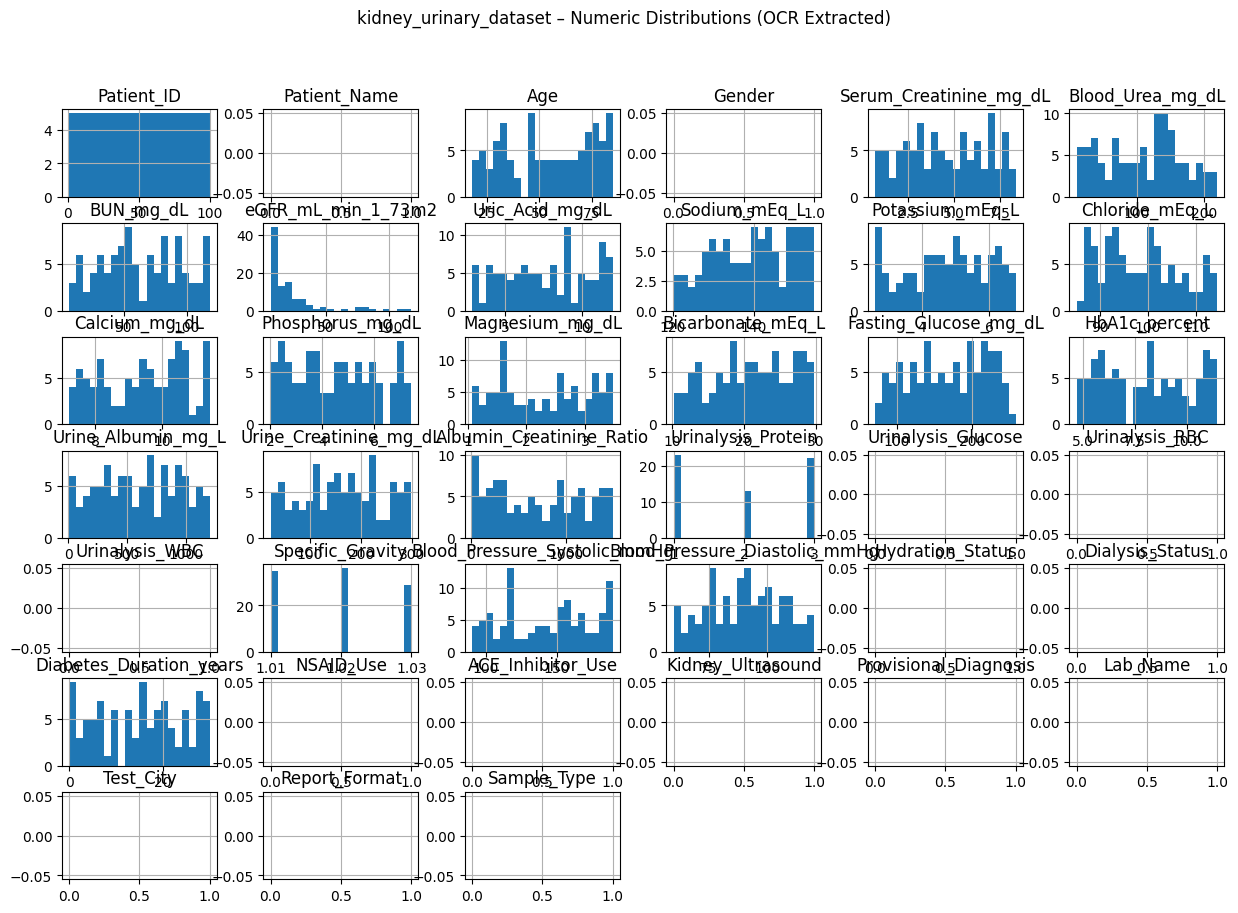

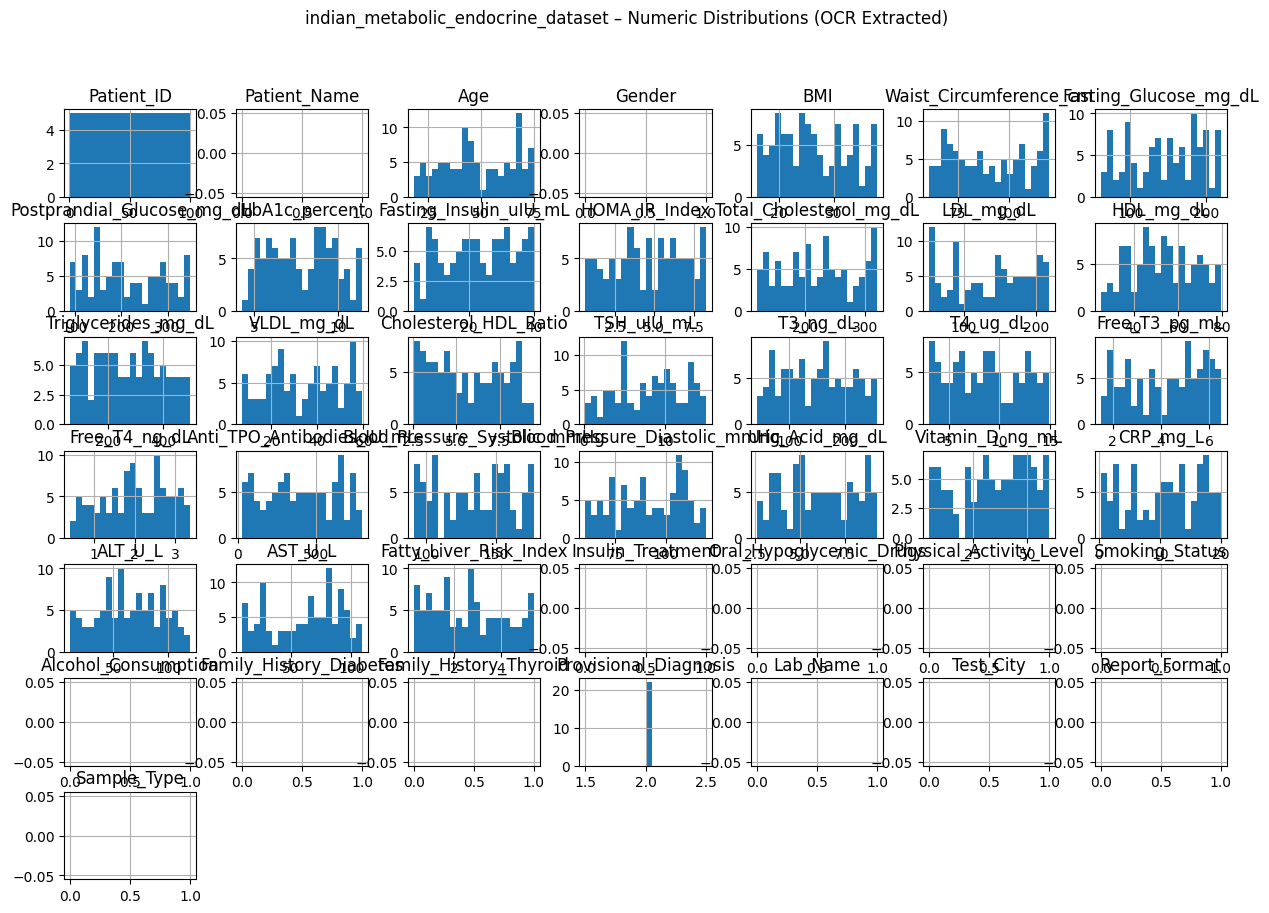

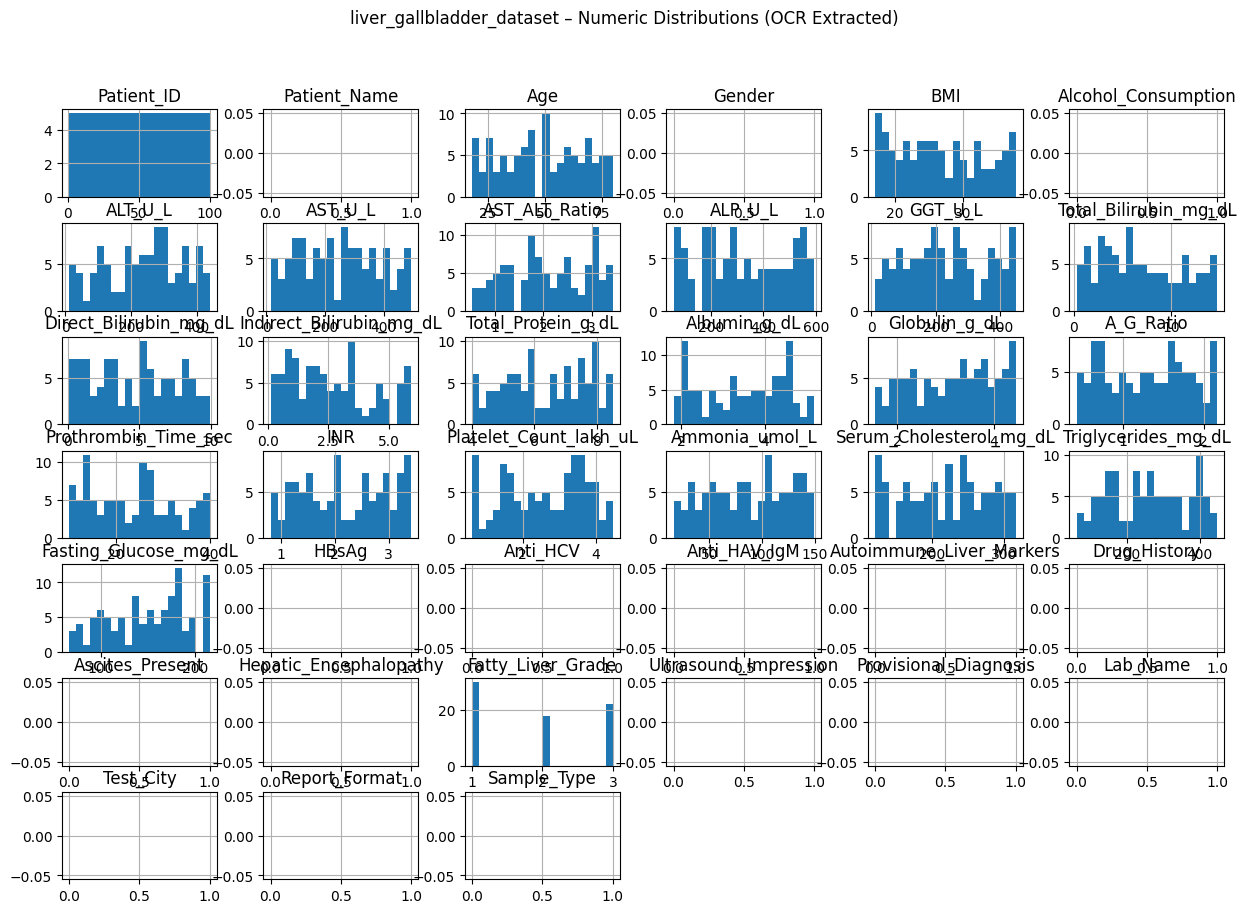

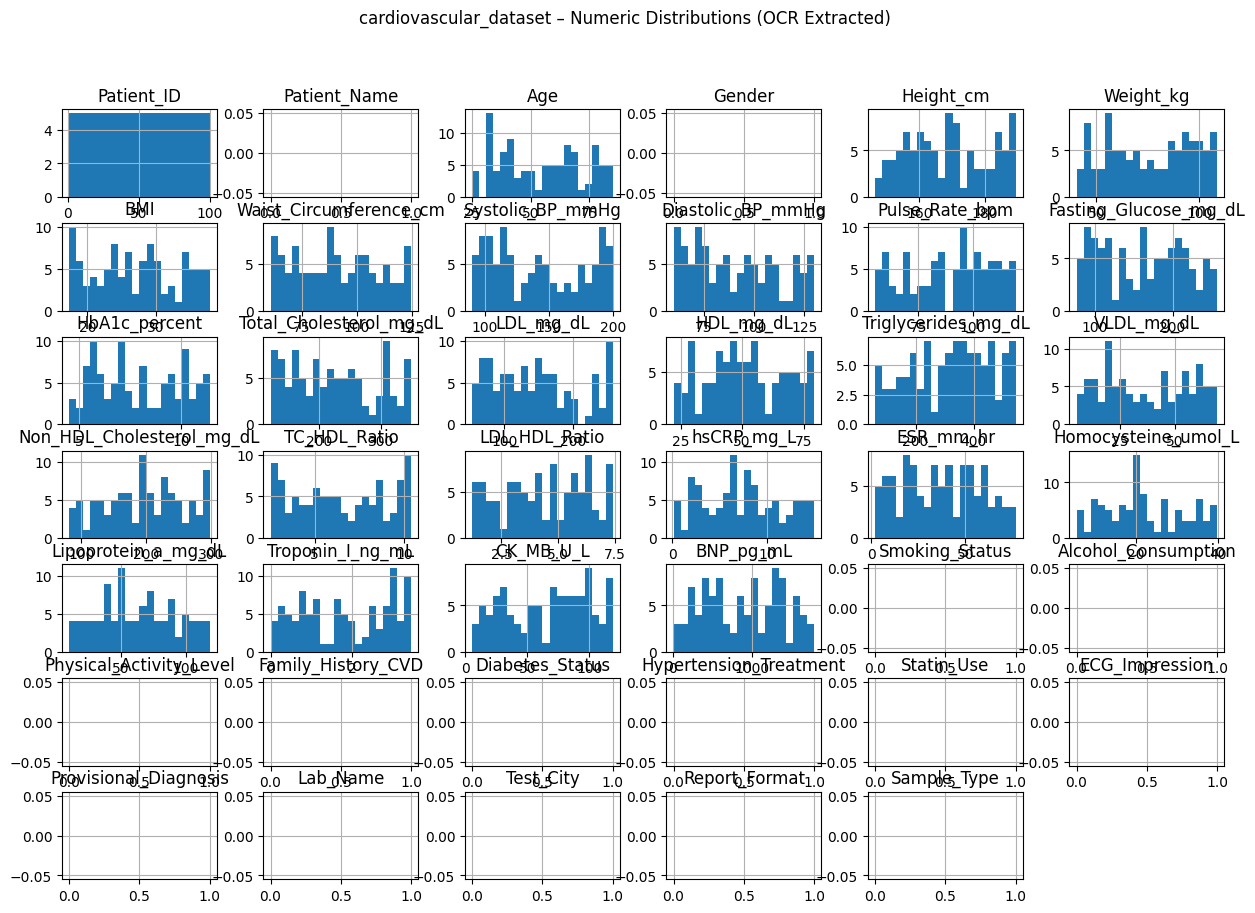

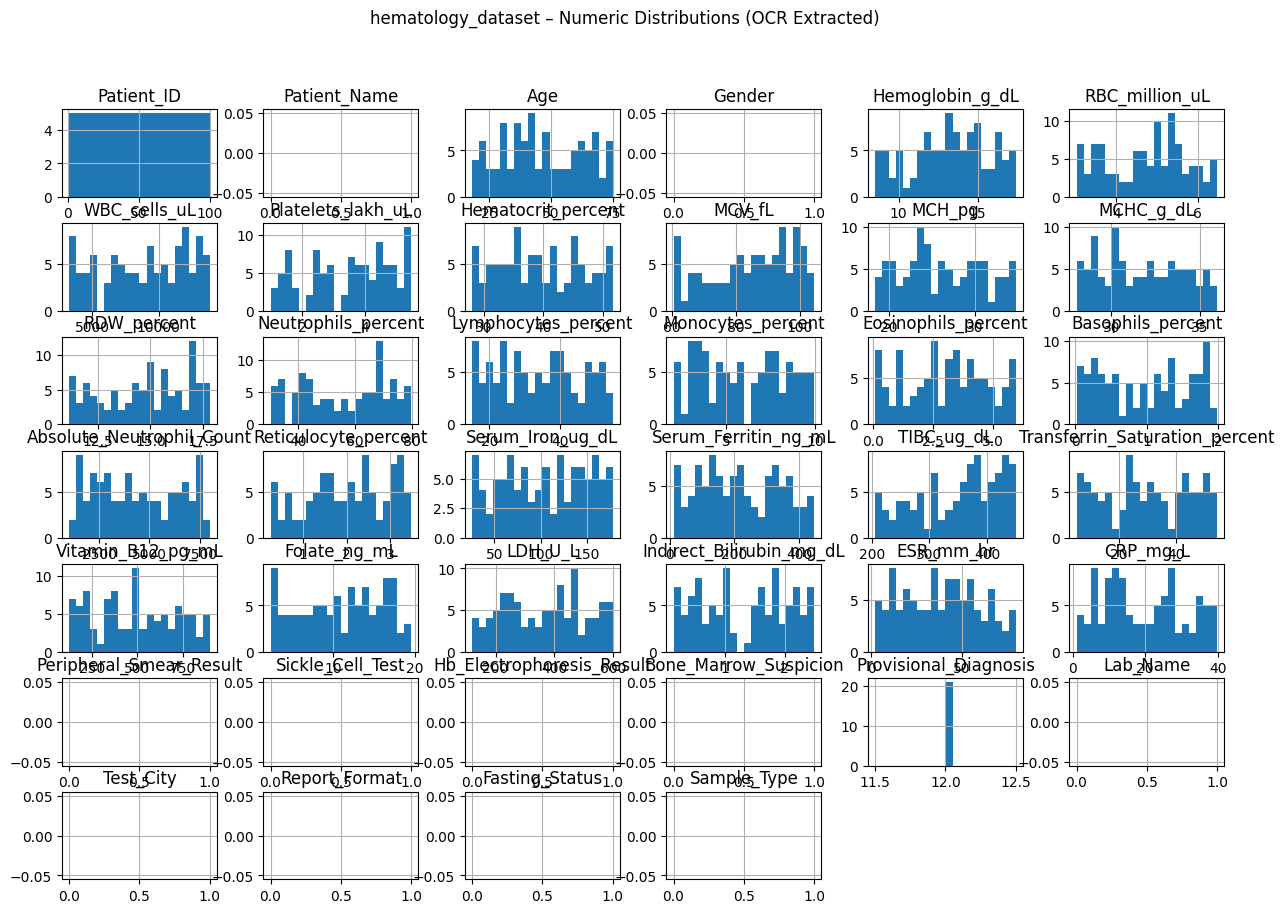

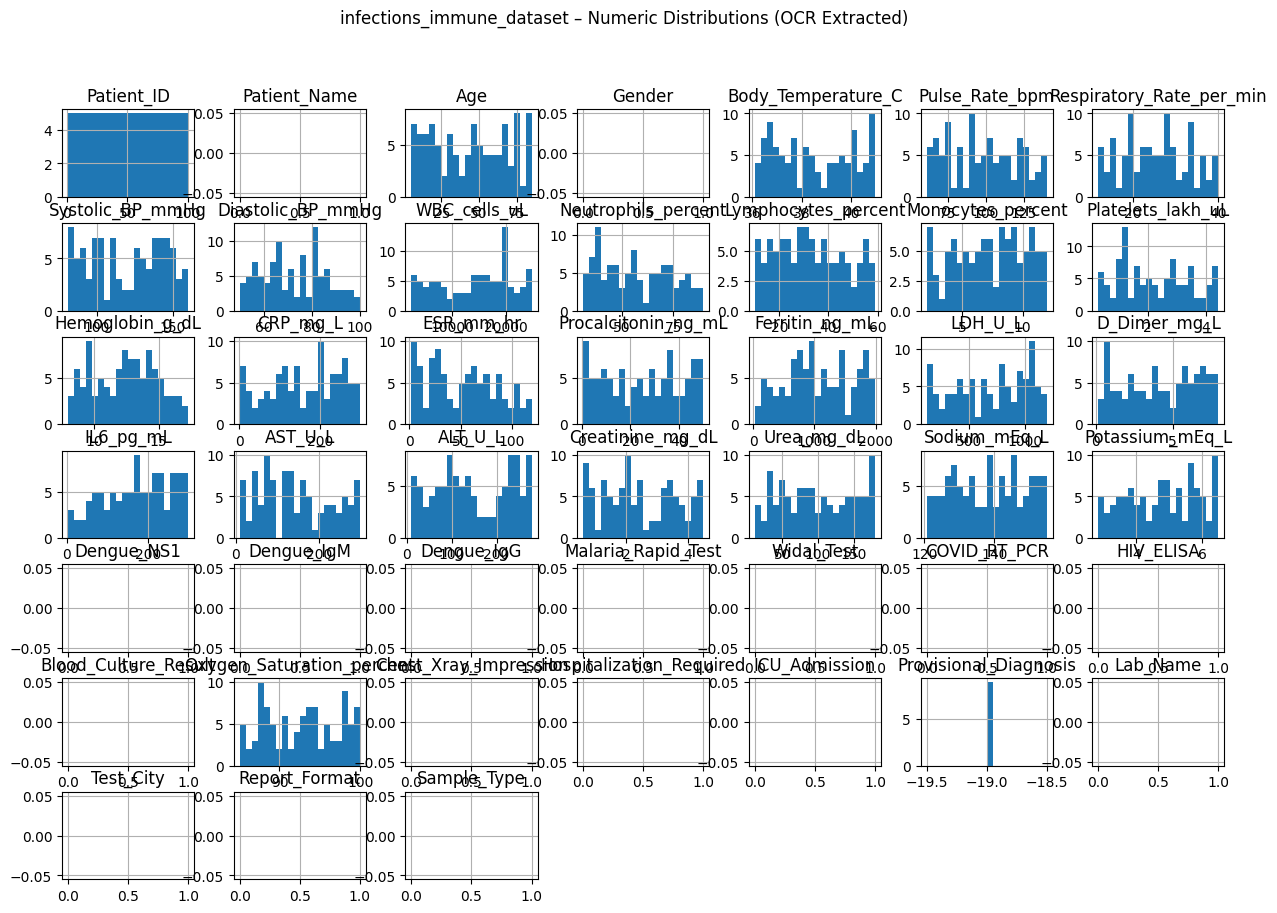

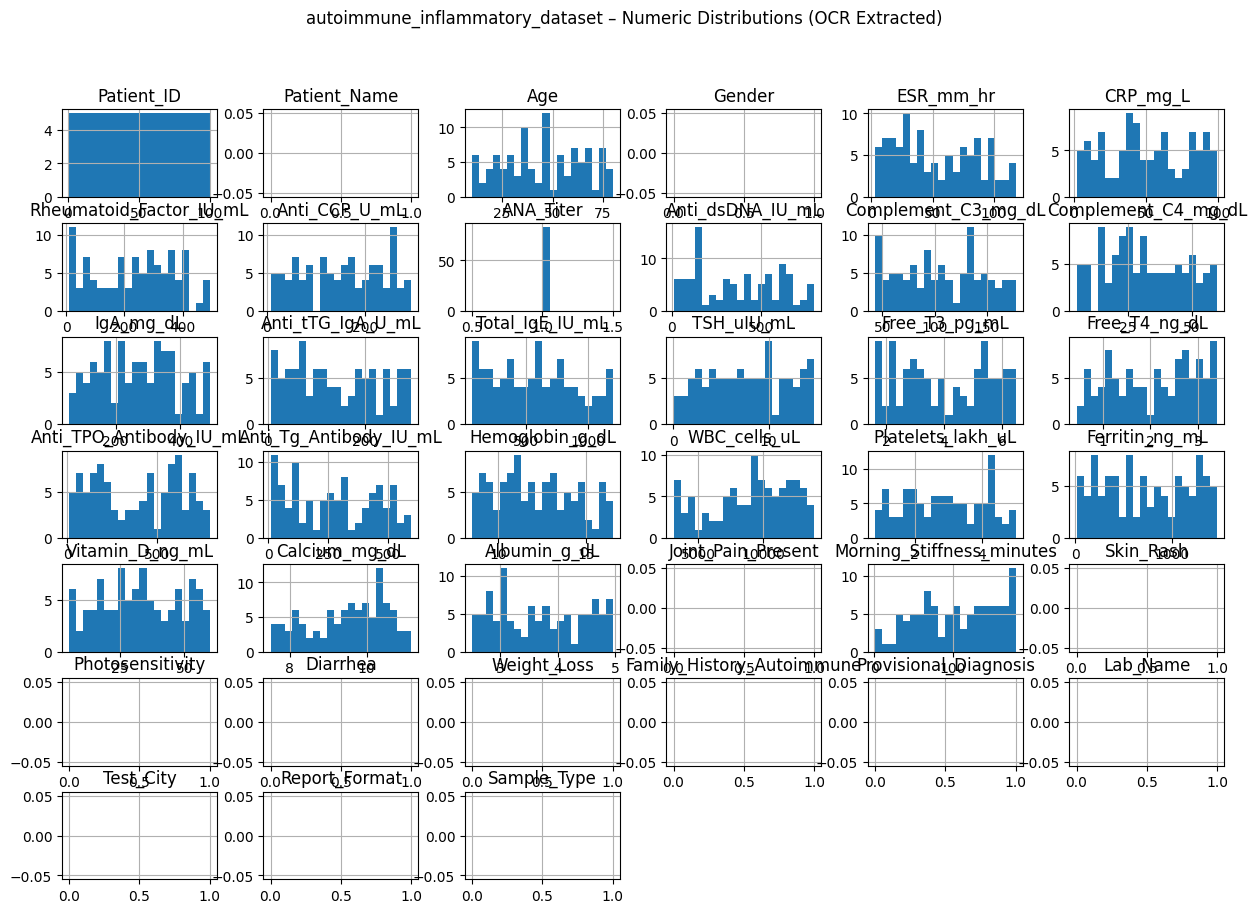

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_numeric_distributions_visual(df, title):
    # Create a temporary numeric-only copy
    temp_df = df.copy()

    for col in temp_df.columns:
        # Try to extract numeric values from strings
        temp_df[col] = (
            temp_df[col]
            .astype(str)
            .str.extract(r"([-+]?\d*\.?\d+)", expand=False)
        )
        temp_df[col] = pd.to_numeric(temp_df[col], errors="coerce")

    numeric_cols = temp_df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) == 0:
        print(f"{title}: No plottable numeric data even after extraction.")
        return

    temp_df[numeric_cols].hist(figsize=(15, 10), bins=20)
    plt.suptitle(f"{title} – Numeric Distributions (OCR Extracted)")
    plt.show()


for name, df in dataset_dfs.items():
    plot_numeric_distributions_visual(df, name)


### Gender & Report Format Breakdown

In [48]:
for name, df in dataset_dfs.items():
    print(f"\n{name}")
    if "Gender" in df.columns:
        display(df["Gender"].value_counts(dropna=False))
    display(df["Report_Format"].value_counts())



kidney_urinary_dataset


Gender
Male      52
Female    48
Name: count, dtype: int64

Report_Format
PDF              51
Scanned Image    49
Name: count, dtype: int64


indian_metabolic_endocrine_dataset


Gender
Male      53
Female    47
Name: count, dtype: int64

Report_Format
PDF              52
Scanned Image    48
Name: count, dtype: int64


liver_gallbladder_dataset


Gender
Male      56
Female    44
Name: count, dtype: int64

Report_Format
Scanned Image    54
PDF              46
Name: count, dtype: int64


cardiovascular_dataset


Gender
Female    54
Male      46
Name: count, dtype: int64

Report_Format
Scanned Image    54
PDF              46
Name: count, dtype: int64


hematology_dataset


Gender
Male      51
Female    49
Name: count, dtype: int64

Report_Format
PDF              53
Scanned Image    47
Name: count, dtype: int64


infections_immune_dataset


Gender
Male      53
Female    47
Name: count, dtype: int64

Report_Format
Scanned Image    56
PDF              44
Name: count, dtype: int64


autoimmune_inflammatory_dataset


Gender
Male      55
Female    45
Name: count, dtype: int64

Report_Format
PDF              51
Scanned Image    49
Name: count, dtype: int64

### Missingness Map

In [49]:
for name, df in dataset_dfs.items():
    print(f"\n{name} – missing values per column")
    display(df.isna().mean().sort_values(ascending=False))



kidney_urinary_dataset – missing values per column


Patient_ID                       0.0
Patient_Name                     0.0
Age                              0.0
Gender                           0.0
Serum_Creatinine_mg_dL           0.0
Blood_Urea_mg_dL                 0.0
BUN_mg_dL                        0.0
eGFR_mL_min_1_73m2               0.0
Uric_Acid_mg_dL                  0.0
Sodium_mEq_L                     0.0
Potassium_mEq_L                  0.0
Chloride_mEq_L                   0.0
Calcium_mg_dL                    0.0
Phosphorus_mg_dL                 0.0
Magnesium_mg_dL                  0.0
Bicarbonate_mEq_L                0.0
Fasting_Glucose_mg_dL            0.0
HbA1c_percent                    0.0
Urine_Albumin_mg_L               0.0
Urine_Creatinine_mg_dL           0.0
Albumin_Creatinine_Ratio         0.0
Urinalysis_Protein               0.0
Urinalysis_Glucose               0.0
Urinalysis_RBC                   0.0
Urinalysis_WBC                   0.0
Specific_Gravity                 0.0
Blood_Pressure_Systolic_mmHg     0.0
B


indian_metabolic_endocrine_dataset – missing values per column


Patient_ID                       0.0
Patient_Name                     0.0
Age                              0.0
Gender                           0.0
BMI                              0.0
Waist_Circumference_cm           0.0
Fasting_Glucose_mg_dL            0.0
Postprandial_Glucose_mg_dL       0.0
HbA1c_percent                    0.0
Fasting_Insulin_uIU_mL           0.0
HOMA_IR_Index                    0.0
Total_Cholesterol_mg_dL          0.0
LDL_mg_dL                        0.0
HDL_mg_dL                        0.0
Triglycerides_mg_dL              0.0
VLDL_mg_dL                       0.0
Cholesterol_HDL_Ratio            0.0
TSH_uIU_mL                       0.0
T3_ng_dL                         0.0
T4_ug_dL                         0.0
Free_T3_pg_mL                    0.0
Free_T4_ng_dL                    0.0
Anti_TPO_Antibodies_IU_mL        0.0
Blood_Pressure_Systolic_mmHg     0.0
Blood_Pressure_Diastolic_mmHg    0.0
Uric_Acid_mg_dL                  0.0
Vitamin_D_ng_mL                  0.0
C


liver_gallbladder_dataset – missing values per column


Fatty_Liver_Grade           0.3
Patient_Name                0.0
Patient_ID                  0.0
Gender                      0.0
BMI                         0.0
Alcohol_Consumption         0.0
Age                         0.0
ALT_U_L                     0.0
AST_U_L                     0.0
ALP_U_L                     0.0
AST_ALT_Ratio               0.0
Total_Bilirubin_mg_dL       0.0
Direct_Bilirubin_mg_dL      0.0
Indirect_Bilirubin_mg_dL    0.0
GGT_U_L                     0.0
Albumin_g_dL                0.0
Globulin_g_dL               0.0
A_G_Ratio                   0.0
Prothrombin_Time_sec        0.0
INR                         0.0
Platelet_Count_lakh_uL      0.0
Ammonia_umol_L              0.0
Total_Protein_g_dL          0.0
Serum_Cholesterol_mg_dL     0.0
Triglycerides_mg_dL         0.0
HBsAg                       0.0
Fasting_Glucose_mg_dL       0.0
Anti_HAV_IgM                0.0
Autoimmune_Liver_Markers    0.0
Drug_History                0.0
Anti_HCV                    0.0
Ascites_


cardiovascular_dataset – missing values per column


Patient_ID                   0.0
Patient_Name                 0.0
Age                          0.0
Gender                       0.0
Height_cm                    0.0
Weight_kg                    0.0
BMI                          0.0
Waist_Circumference_cm       0.0
Systolic_BP_mmHg             0.0
Diastolic_BP_mmHg            0.0
Pulse_Rate_bpm               0.0
Fasting_Glucose_mg_dL        0.0
HbA1c_percent                0.0
Total_Cholesterol_mg_dL      0.0
LDL_mg_dL                    0.0
HDL_mg_dL                    0.0
Triglycerides_mg_dL          0.0
VLDL_mg_dL                   0.0
Non_HDL_Cholesterol_mg_dL    0.0
TC_HDL_Ratio                 0.0
LDL_HDL_Ratio                0.0
hsCRP_mg_L                   0.0
ESR_mm_hr                    0.0
Homocysteine_umol_L          0.0
Lipoprotein_a_mg_dL          0.0
Troponin_I_ng_mL             0.0
CK_MB_U_L                    0.0
BNP_pg_mL                    0.0
Smoking_Status               0.0
Alcohol_Consumption          0.0
Physical_A


hematology_dataset – missing values per column


Patient_ID                        0.0
Patient_Name                      0.0
Age                               0.0
Gender                            0.0
Hemoglobin_g_dL                   0.0
RBC_million_uL                    0.0
WBC_cells_uL                      0.0
Platelets_lakh_uL                 0.0
Hematocrit_percent                0.0
MCV_fL                            0.0
MCH_pg                            0.0
MCHC_g_dL                         0.0
RDW_percent                       0.0
Neutrophils_percent               0.0
Lymphocytes_percent               0.0
Monocytes_percent                 0.0
Eosinophils_percent               0.0
Basophils_percent                 0.0
Absolute_Neutrophil_Count         0.0
Reticulocyte_percent              0.0
Serum_Iron_ug_dL                  0.0
Serum_Ferritin_ng_mL              0.0
TIBC_ug_dL                        0.0
Transferrin_Saturation_percent    0.0
Vitamin_B12_pg_mL                 0.0
Folate_ng_mL                      0.0
LDH_U_L     


infections_immune_dataset – missing values per column


Patient_ID                   0.0
Patient_Name                 0.0
Age                          0.0
Gender                       0.0
Body_Temperature_C           0.0
Pulse_Rate_bpm               0.0
Respiratory_Rate_per_min     0.0
Systolic_BP_mmHg             0.0
Diastolic_BP_mmHg            0.0
WBC_cells_uL                 0.0
Neutrophils_percent          0.0
Lymphocytes_percent          0.0
Monocytes_percent            0.0
Platelets_lakh_uL            0.0
Hemoglobin_g_dL              0.0
CRP_mg_L                     0.0
ESR_mm_hr                    0.0
Procalcitonin_ng_mL          0.0
Ferritin_ng_mL               0.0
LDH_U_L                      0.0
D_Dimer_mg_L                 0.0
IL6_pg_mL                    0.0
AST_U_L                      0.0
ALT_U_L                      0.0
Creatinine_mg_dL             0.0
Urea_mg_dL                   0.0
Sodium_mEq_L                 0.0
Potassium_mEq_L              0.0
Dengue_NS1                   0.0
Dengue_IgM                   0.0
Dengue_IgG


autoimmune_inflammatory_dataset – missing values per column


Patient_ID                   0.0
Patient_Name                 0.0
Age                          0.0
Gender                       0.0
ESR_mm_hr                    0.0
CRP_mg_L                     0.0
Rheumatoid_Factor_IU_mL      0.0
Anti_CCP_U_mL                0.0
ANA_Titer                    0.0
Anti_dsDNA_IU_mL             0.0
Complement_C3_mg_dL          0.0
Complement_C4_mg_dL          0.0
IgA_mg_dL                    0.0
Anti_tTG_IgA_U_mL            0.0
Total_IgE_IU_mL              0.0
TSH_uIU_mL                   0.0
Free_T3_pg_mL                0.0
Free_T4_ng_dL                0.0
Anti_TPO_Antibody_IU_mL      0.0
Anti_Tg_Antibody_IU_mL       0.0
Hemoglobin_g_dL              0.0
WBC_cells_uL                 0.0
Platelets_lakh_uL            0.0
Ferritin_ng_mL               0.0
Vitamin_D_ng_mL              0.0
Calcium_mg_dL                0.0
Albumin_g_dL                 0.0
Joint_Pain_Present           0.0
Morning_Stiffness_minutes    0.0
Skin_Rash                    0.0
Photosensi

# Milestone 2 — Pattern Recognition & Contextual Analysis

In [50]:
from concurrent.futures import ThreadPoolExecutor, as_completed

### Feature engineering helpers (ratios, safe numeric casting)

In [51]:
# Cell 2
def as_num(x):
    """Safe numeric cast for OCR-extracted strings (returns np.nan on failure)."""
    try:
        return float(x)
    except Exception:
        return np.nan

def compute_ratios(row):
    """Compute useful derived features (adds to a dict)."""
    r = {}
    LDL = as_num(row.get("LDL_mg_dL", np.nan))
    HDL = as_num(row.get("HDL_mg_dL", np.nan))
    TC = as_num(row.get("Total_Cholesterol_mg_dL", np.nan))
    TG = as_num(row.get("Triglycerides_mg_dL", np.nan))
    Gl = as_num(row.get("Fasting_Glucose_mg_dL", np.nan))
    # Lipid ratios
    if HDL and HDL > 0:
        r["TC_HDL_Ratio"] = TC / HDL if (not np.isnan(TC)) else np.nan
        r["LDL_HDL_Ratio"] = LDL / HDL if (not np.isnan(LDL)) else np.nan
    else:
        r["TC_HDL_Ratio"] = np.nan
        r["LDL_HDL_Ratio"] = np.nan
    # Atherogenic index (log TG/HDL) — common simple proxy
    if TG and HDL and TG>0 and HDL>0:
        r["Atherogenic_Index"] = np.log(TG/HDL)
    else:
        r["Atherogenic_Index"] = np.nan
    # Metabolic features
    r["Fasting_Glucose_mg_dL"] = Gl
    r["Triglycerides_mg_dL"] = TG
    return r


### Model 2: pattern detectors & risk scorers

In [52]:
# Cell 3
def detect_metabolic_syndrome_flags(row):
    """Return count of metabolic syndrome criteria present (ATP-like simplified)."""
    flags = 0
    # criteria thresholds (simplified for screening)
    if as_num(row.get("Fasting_Glucose_mg_dL", np.nan)) >= 100: flags += 1
    if as_num(row.get("Triglycerides_mg_dL", np.nan)) >= 150: flags += 1
    if as_num(row.get("HDL_mg_dL", np.nan)) < 40: flags += 1
    if as_num(row.get("Waist_Circumference_cm", np.nan)) > 90: flags += 1
    return flags

def cardiovascular_risk_score(row):
    """Simple additive score; explainable and directionally correct."""
    score = 0
    LDL = as_num(row.get("LDL_mg_dL", np.nan))
    HDL = as_num(row.get("HDL_mg_dL", np.nan))
    TG = as_num(row.get("Triglycerides_mg_dL", np.nan))
    sbp = as_num(row.get("Systolic_BP_mmHg", np.nan))
    crp = as_num(row.get("CRP_mg_L", np.nan))
    # Add points
    if LDL and LDL > 160: score += 3
    elif LDL and LDL > 130: score += 2
    if HDL and HDL < 40: score += 2
    if TG and TG > 200: score += 1
    if sbp and sbp > 140: score += 2
    if crp and crp > 3: score += 1
    return score

def infection_severity_label(row):
    """Return Low/Moderate/High based on CRP/Procalcitonin/LDH/D-dimer heuristics."""
    crp = as_num(row.get("CRP_mg_L", np.nan))
    pct = as_num(row.get("Procalcitonin_ng_mL", np.nan))
    d_dimer = as_num(row.get("D_Dimer_mg_L", np.nan))
    if (crp and crp>100) or (pct and pct>2) or (d_dimer and d_dimer>2):
        return "High"
    if (crp and crp>10) or (pct and pct>0.5):
        return "Moderate"
    return "Low"

def liver_injury_flag(row):
    """Flag probable liver injury (ALT/AST / bilirubin thresholds)."""
    alt = as_num(row.get("ALT_U_L", np.nan))
    ast = as_num(row.get("AST_U_L", np.nan))
    tb = as_num(row.get("Total_Bilirubin_mg_dL", np.nan))
    if alt and alt>200 or ast and ast>200 or (tb and tb>3):
        return True
    return False

def kidney_risk_stage(row):
    """Simplified eGFR-based stage estimate (if eGFR present)."""
    egfr = as_num(row.get("eGFR_mL_min_1_73m2", np.nan))
    if np.isnan(egfr): return None
    if egfr >= 90: return "G1"
    if egfr >= 60: return "G2"
    if egfr >= 30: return "G3"
    if egfr >= 15: return "G4"
    return "G5"


### Model 3: contextual adjustments (age & gender)

In [53]:
def contextual_adjustments(row, cv_score_col="Cardiovascular_Risk_Score"):
    adj = {}

    # Base cardiovascular score
    base = as_num(row.get(cv_score_col, np.nan))
    if np.isnan(base):
        base = 0

    # Age handling
    age = as_num(row.get("Age", np.nan))

    # Gender handling (SAFE)
    gender_raw = row.get("Gender", "")
    if isinstance(gender_raw, str):
        gender = gender_raw.lower()
    else:
        gender = ""

    adj_score = base

    if age and age >= 60:
        adj_score += 1

    if gender == "male":
        adj_score += 1

    adj["Adjusted_Cardiovascular_Risk"] = adj_score
    return adj


### Integrator: run Model2 & Model3 on a DataFrame (per-dataset)

In [54]:
# Cell 5
def run_models_on_df(df):
    df = df.copy()
    # derived features (vectorized where possible)
    # compute ratios per-row to avoid overwriting original
    ratio_dicts = df.apply(compute_ratios, axis=1)
    ratio_df = pd.DataFrame(list(ratio_dicts))
    df = pd.concat([df.reset_index(drop=True), ratio_df.reset_index(drop=True)], axis=1)

    # Model 2 outputs
    df["Metabolic_Syndrome_Flags"] = df.apply(detect_metabolic_syndrome_flags, axis=1)
    df["Cardiovascular_Risk_Score"] = df.apply(cardiovascular_risk_score, axis=1)
    df["Infection_Severity"] = df.apply(infection_severity_label, axis=1)
    df["Liver_Injury_Flag"] = df.apply(liver_injury_flag, axis=1)
    df["Kidney_Risk_Stage"] = df.apply(kidney_risk_stage, axis=1)

    # Model 3 contextual adjustments
    adj_df = df.apply(contextual_adjustments, axis=1, result_type="expand")
    df = pd.concat([df, adj_df], axis=1)

    return df


### Run in parallel across the 8 dataset DataFrames

In [55]:
# Cell 6
# Assumes dataset_dfs dict exists: {dataset_name: dataframe}
processed_dataset_dfs = {}

def process_dataset_pair(name, df):
    return name, run_models_on_df(df)

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(process_dataset_pair, name, df) for name, df in dataset_dfs.items()]
    for fut in as_completed(futures):
        name, processed_df = fut.result()
        processed_dataset_dfs[name] = processed_df

# Quick check
for name, df in processed_dataset_dfs.items():
    print(name, "->", df.shape)
    display(df.head(10))


infections_immune_dataset -> (100, 56)


,Patient_ID,Patient_Name,Age,Gender,Body_Temperature_C,Pulse_Rate_bpm,Respiratory_Rate_per_min,Systolic_BP_mmHg,Diastolic_BP_mmHg,WBC_cells_uL,...,LDL_HDL_Ratio,Atherogenic_Index,Fasting_Glucose_mg_dL,Triglycerides_mg_dL,Metabolic_Syndrome_Flags,Cardiovascular_Risk_Score,Infection_Severity,Liver_Injury_Flag,Kidney_Risk_Stage,Adjusted_Cardiovascular_Risk
0,IND_INF_0001,Kavita Nair,9,Female,36.65,125,16,138,74,2361,...,NaN,NaN,NaN,NaN,0,1,High,True,None,1.0
1,IND_INF_0002,Amit Sharma,48,Male,39.43,96,32,86,65,3498,...,NaN,NaN,NaN,NaN,0,1,High,False,None,2.0
2,IND_INF_0003,Manish Pandey,84,Female,38.32,71,39,85,82,16973,...,NaN,NaN,NaN,NaN,0,1,High,False,None,2.0
3,IND_INF_0004,Pankaj Mondal,30,Female,39.10,65,28,100,71,23867,...,NaN,NaN,NaN,NaN,0,1,High,False,None,1.0
4,IND_INF_0005,Priya Singh,73,Female,36.40,62,34,114,92,14571,...,NaN,NaN,NaN,NaN,0,1,High,True,None,2.0
5,IND_INF_0006,Manish Pandey,13,Female,40.53,86,28,115,84,19548,...,NaN,NaN,NaN,NaN,0,1,High,True,None,1.0
6,IND_INF_0007,Pankaj Mondal,74,Female,40.82,140,13,81,65,20225,...,NaN,NaN,NaN,NaN,0,1,High,False,None,2.0
7,IND_INF_0008,Kavita Nair,81,Female,40.50,116,28,102,76,24499,...,NaN,NaN,NaN,NaN,0,1,High,True,None,2.0
8,IND_INF_0009,Rohit Agarwal,5,Male,36.42,84,18,149,68,11174,...,NaN,NaN,NaN,NaN,0,3,High,False,None,4.0
9,IND_INF_0010,Nikhil Mehta,33,Female,36.45,96,23,111,80,3676,...,NaN,NaN,NaN,NaN,0,0,High,True,None,0.0


kidney_urinary_dataset -> (100, 50)


,Patient_ID,Patient_Name,Age,Gender,Serum_Creatinine_mg_dL,Blood_Urea_mg_dL,BUN_mg_dL,eGFR_mL_min_1_73m2,Uric_Acid_mg_dL,Sodium_mEq_L,...,LDL_HDL_Ratio,Atherogenic_Index,Fasting_Glucose_mg_dL,Triglycerides_mg_dL,Metabolic_Syndrome_Flags,Cardiovascular_Risk_Score,Infection_Severity,Liver_Injury_Flag,Kidney_Risk_Stage,Adjusted_Cardiovascular_Risk
0,IND_KID_0001,Ritu Banerjee,74,Female,7.44,146.27,95.82,7.21,10.22,138.99,...,NaN,NaN,235.97,NaN,0,0,Low,False,G5,1.0
1,IND_KID_0002,Suman Roy,32,Female,3.13,26.42,6.44,23.21,4.01,132.81,...,NaN,NaN,196.97,NaN,0,0,Low,False,G4,0.0
2,IND_KID_0003,Pankaj Mondal,23,Female,3.99,75.77,43.72,18.75,6.08,130.71,...,NaN,NaN,91.35,NaN,0,0,Low,False,G4,0.0
3,IND_KID_0004,Ravi Kumar,25,Female,7.82,64.17,54.90,8.48,10.58,152.26,...,NaN,NaN,219.70,NaN,0,0,Low,False,G5,0.0
4,IND_KID_0005,Deepak Yadav,61,Male,7.93,128.34,45.11,6.96,9.94,127.68,...,NaN,NaN,205.16,NaN,0,0,Low,False,G5,2.0
5,IND_KID_0006,Sourav Das,57,Male,2.28,176.64,55.53,29.75,11.32,129.71,...,NaN,NaN,231.19,NaN,0,0,Low,False,G4,1.0
6,IND_KID_0007,Sneha Kulkarni,81,Female,4.43,127.55,16.21,12.87,4.53,134.71,...,NaN,NaN,137.17,NaN,0,0,Low,False,G5,1.0
7,IND_KID_0008,Nikhil Mehta,71,Male,5.46,70.72,59.36,10.39,8.66,132.63,...,NaN,NaN,76.41,NaN,0,0,Low,False,G5,2.0
8,IND_KID_0009,Deepak Yadav,38,Female,5.63,33.67,82.08,11.38,5.15,148.38,...,NaN,NaN,141.20,NaN,0,0,Low,False,G5,0.0
9,IND_KID_0010,Nikhil Mehta,33,Male,2.24,32.57,17.62,33.93,11.73,134.57,...,NaN,NaN,207.66,NaN,0,0,Low,False,G3,1.0


hematology_dataset -> (100, 51)


,Patient_ID,Patient_Name,Age,Gender,Hemoglobin_g_dL,RBC_million_uL,WBC_cells_uL,Platelets_lakh_uL,Hematocrit_percent,MCV_fL,...,LDL_HDL_Ratio,Atherogenic_Index,Fasting_Glucose_mg_dL,Triglycerides_mg_dL,Metabolic_Syndrome_Flags,Cardiovascular_Risk_Score,Infection_Severity,Liver_Injury_Flag,Kidney_Risk_Stage,Adjusted_Cardiovascular_Risk
0,IND0001,Rohit Agarwal,57,Female,17.43,4.38,7293,4.62,48.06,82.37,...,NaN,NaN,NaN,NaN,0,1,Low,False,None,1.0
1,IND0002,Ankit Gupta,18,Male,12.75,4.05,11678,1.60,37.55,87.52,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,2.0
2,IND0003,Ankit Gupta,54,Female,17.01,4.63,9132,4.80,31.65,89.76,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,1.0
3,IND0004,Arjun Malhotra,48,Male,12.88,5.55,5236,2.50,44.96,79.49,...,NaN,NaN,NaN,NaN,0,1,Low,False,None,2.0
4,IND0005,Deepak Yadav,37,Male,12.03,3.95,11356,3.74,37.84,84.18,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,2.0
5,IND0006,Nikhil Mehta,55,Male,11.97,5.72,7687,3.72,38.75,71.63,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,2.0
6,IND0007,Nikhil Mehta,49,Female,13.24,5.41,9356,4.69,35.88,66.26,...,NaN,NaN,NaN,NaN,0,1,Low,False,None,1.0
7,IND0008,Nikhil Mehta,37,Female,16.12,5.67,6878,2.83,38.81,93.83,...,NaN,NaN,NaN,NaN,0,1,Low,False,None,1.0
8,IND0009,Priya Singh,57,Male,14.95,5.45,10736,4.40,37.29,62.40,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,2.0
9,IND0010,Ritu Banerjee,43,Male,12.00,4.54,9716,3.42,35.93,99.34,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,2.0


indian_metabolic_endocrine_dataset -> (100, 54)


,Patient_ID,Patient_Name,Age,Gender,BMI,Waist_Circumference_cm,Fasting_Glucose_mg_dL,Postprandial_Glucose_mg_dL,HbA1c_percent,Fasting_Insulin_uIU_mL,...,LDL_HDL_Ratio,Atherogenic_Index,Fasting_Glucose_mg_dL,Triglycerides_mg_dL,Metabolic_Syndrome_Flags,Cardiovascular_Risk_Score,Infection_Severity,Liver_Injury_Flag,Kidney_Risk_Stage,Adjusted_Cardiovascular_Risk
0,IND_MET_0001,Vikram Rao,73,Female,31.09,104.82,108.15,349.05,11.36,10.42,...,2.533726,1.549078,108.15,271.46,1,3,Moderate,False,None,4.0
1,IND_MET_0002,Kavita Nair,67,Female,24.96,104.01,214.45,162.28,7.14,15.59,...,1.218429,0.733701,214.45,93.35,1,1,Low,False,None,2.0
2,IND_MET_0003,Deepak Yadav,68,Male,19.54,111.73,67.06,290.31,6.20,21.23,...,4.508565,2.491000,67.06,451.06,2,6,Moderate,False,None,8.0
3,IND_MET_0004,Anjali Iyer,68,Female,24.16,84.36,74.33,275.45,5.75,22.54,...,0.797513,0.812048,74.33,152.18,0,1,Low,False,None,2.0
4,IND_MET_0005,Sneha Kulkarni,34,Female,31.91,72.38,196.63,144.32,6.01,32.81,...,2.262772,2.131613,196.63,298.62,1,2,Low,False,None,2.0
5,IND_MET_0006,Rohit Agarwal,69,Female,33.74,72.84,135.05,153.01,11.44,21.75,...,3.559957,2.301156,135.05,461.34,0,3,Low,False,None,4.0
6,IND_MET_0007,Neha Patel,44,Female,36.24,107.90,190.97,345.63,5.25,29.47,...,3.319512,1.747224,190.97,305.87,1,4,Moderate,False,None,4.0
7,IND_MET_0008,Manish Pandey,63,Male,25.76,79.64,163.84,276.88,7.17,32.60,...,3.011076,1.972186,163.84,298.45,0,1,Low,False,None,3.0
8,IND_MET_0009,Suman Roy,22,Male,17.97,116.58,151.87,198.22,5.84,18.89,...,3.302811,1.759795,151.87,361.75,1,4,Low,False,None,5.0
9,IND_MET_0010,Deepak Yadav,52,Female,24.99,84.59,197.54,193.10,5.18,9.43,...,2.531542,1.639458,197.54,391.22,0,3,Low,False,None,3.0


liver_gallbladder_dataset -> (100, 50)


,Patient_ID,Patient_Name,Age,Gender,BMI,Alcohol_Consumption,ALT_U_L,AST_U_L,AST_ALT_Ratio,ALP_U_L,...,LDL_HDL_Ratio,Atherogenic_Index,Fasting_Glucose_mg_dL,Triglycerides_mg_dL,Metabolic_Syndrome_Flags,Cardiovascular_Risk_Score,Infection_Severity,Liver_Injury_Flag,Kidney_Risk_Stage,Adjusted_Cardiovascular_Risk
0,IND_LIV_0001,Suman Roy,41,Female,21.16,Heavy,292,85,1.80,532,...,NaN,NaN,120.37,380.42,0,0,Low,True,None,0.0
1,IND_LIV_0002,Sneha Kulkarni,30,Female,17.21,No,232,102,2.52,60,...,NaN,NaN,180.50,304.20,0,0,Low,True,None,0.0
2,IND_LIV_0003,Amit Sharma,19,Male,26.84,No,289,133,3.03,105,...,NaN,NaN,177.40,219.69,0,0,Low,True,None,1.0
3,IND_LIV_0004,Kavita Nair,25,Male,28.37,Regular,327,495,2.03,216,...,NaN,NaN,152.12,274.95,0,0,Low,True,None,1.0
4,IND_LIV_0005,Vikram Rao,80,Female,20.60,Heavy,85,258,3.33,89,...,NaN,NaN,215.21,264.50,0,0,Low,True,None,1.0
5,IND_LIV_0006,Rahul Verma,25,Female,18.52,Heavy,321,40,3.00,74,...,NaN,NaN,193.77,319.25,0,0,Low,True,None,0.0
6,IND_LIV_0007,Ravi Kumar,43,Male,34.10,Regular,299,118,3.08,582,...,NaN,NaN,211.26,380.61,0,0,Low,True,None,1.0
7,IND_LIV_0008,Ankit Gupta,25,Female,25.59,Occasional,38,172,1.81,432,...,NaN,NaN,195.05,156.30,0,0,Low,True,None,0.0
8,IND_LIV_0009,Amit Sharma,22,Female,26.31,Occasional,193,163,1.26,192,...,NaN,NaN,178.54,110.22,0,0,Low,False,None,0.0
9,IND_LIV_0010,Manish Pandey,75,Male,21.82,Regular,404,66,2.94,125,...,NaN,NaN,183.59,160.91,0,0,Low,True,None,2.0


autoimmune_inflammatory_dataset -> (100, 50)


,Patient_ID,Patient_Name,Age,Gender,ESR_mm_hr,CRP_mg_L,Rheumatoid_Factor_IU_mL,Anti_CCP_U_mL,ANA_Titer,Anti_dsDNA_IU_mL,...,LDL_HDL_Ratio,Atherogenic_Index,Fasting_Glucose_mg_dL,Triglycerides_mg_dL,Metabolic_Syndrome_Flags,Cardiovascular_Risk_Score,Infection_Severity,Liver_Injury_Flag,Kidney_Risk_Stage,Adjusted_Cardiovascular_Risk
0,IND_AUTO_0001,Deepak Yadav,57,Male,37,9.57,108.52,256.53,1:160,626.72,...,NaN,NaN,NaN,NaN,0,1,Low,False,None,2.0
1,IND_AUTO_0002,Amit Sharma,57,Male,22,1.91,194.50,128.32,1:80,130.21,...,NaN,NaN,NaN,NaN,0,0,Low,False,None,1.0
2,IND_AUTO_0003,Suman Roy,38,Female,65,49.49,184.38,176.01,1:80,413.98,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,1.0
3,IND_AUTO_0004,Neha Patel,79,Male,96,87.52,469.48,51.57,1:320,519.08,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,3.0
4,IND_AUTO_0005,Anjali Iyer,62,Female,27,70.28,21.82,252.98,1:160,224.85,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,2.0
5,IND_AUTO_0006,Sourav Das,46,Female,27,25.28,61.14,122.84,1:320,41.00,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,1.0
6,IND_AUTO_0007,Ankit Gupta,47,Female,82,2.60,20.78,233.93,1:80,160.10,...,NaN,NaN,NaN,NaN,0,0,Low,False,None,0.0
7,IND_AUTO_0008,Nikhil Mehta,75,Male,30,17.73,64.63,15.59,1:320,150.11,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,3.0
8,IND_AUTO_0009,Nikhil Mehta,73,Male,88,60.29,240.90,153.86,Negative,746.10,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,3.0
9,IND_AUTO_0010,Vikram Rao,45,Female,34,65.59,112.11,236.91,1:80,165.78,...,NaN,NaN,NaN,NaN,0,1,Moderate,False,None,1.0


cardiovascular_dataset -> (100, 52)


,Patient_ID,Patient_Name,Age,Gender,Height_cm,Weight_kg,BMI,Waist_Circumference_cm,Systolic_BP_mmHg,Diastolic_BP_mmHg,...,LDL_HDL_Ratio,Atherogenic_Index,Fasting_Glucose_mg_dL,Triglycerides_mg_dL,Metabolic_Syndrome_Flags,Cardiovascular_Risk_Score,Infection_Severity,Liver_Injury_Flag,Kidney_Risk_Stage,Adjusted_Cardiovascular_Risk
0,IND_CARD_0001,Deepak Yadav,49,Female,165.08,89.90,19.90,74.05,100,108,...,1.182637,1.252892,174.48,233.06,0,0,Low,False,None,0.0
1,IND_CARD_0002,Rahul Verma,48,Female,171.83,87.28,26.48,69.09,136,83,...,6.107240,2.598748,194.74,397.49,1,5,Low,False,None,5.0
2,IND_CARD_0003,Arjun Malhotra,53,Female,188.06,97.50,28.50,90.12,188,62,...,2.230508,0.409797,257.92,84.44,1,2,Low,False,None,2.0
3,IND_CARD_0004,Vikram Rao,73,Female,168.99,93.30,29.31,70.86,114,77,...,3.265865,0.984538,256.86,126.95,0,2,Low,False,None,3.0
4,IND_CARD_0005,Sourav Das,45,Male,184.99,101.04,21.76,64.84,100,77,...,1.927038,1.164806,160.40,191.10,0,0,Low,False,None,1.0
5,IND_CARD_0006,Ritu Banerjee,66,Female,189.62,47.23,18.96,100.73,138,71,...,9.192376,0.775188,196.03,60.94,2,5,Low,False,None,6.0
6,IND_CARD_0007,Vikram Rao,32,Female,189.62,100.10,19.18,118.67,185,68,...,1.367126,1.429684,188.66,324.29,1,2,Low,False,None,2.0
7,IND_CARD_0008,Deepak Yadav,60,Female,182.58,64.32,35.06,112.15,113,108,...,8.847752,2.409233,238.80,294.49,2,5,Low,False,None,6.0
8,IND_CARD_0009,Manish Pandey,31,Male,181.87,94.26,29.40,66.18,97,79,...,2.362553,1.352396,209.42,210.85,0,0,Low,False,None,1.0
9,IND_CARD_0010,Ravi Kumar,62,Male,155.57,53.62,17.78,71.25,114,100,...,9.484223,2.182965,82.74,219.33,1,5,Low,False,None,7.0


In [56]:
for name, df in processed_dataset_dfs.items():
    print(name)
    display(df[["Age", "Gender", "Cardiovascular_Risk_Score", "Adjusted_Cardiovascular_Risk"]].head())


infections_immune_dataset


,Age,Gender,Cardiovascular_Risk_Score,Adjusted_Cardiovascular_Risk
0,9,Female,1,1.0
1,48,Male,1,2.0
2,84,Female,1,2.0
3,30,Female,1,1.0
4,73,Female,1,2.0


kidney_urinary_dataset


,Age,Gender,Cardiovascular_Risk_Score,Adjusted_Cardiovascular_Risk
0,74,Female,0,1.0
1,32,Female,0,0.0
2,23,Female,0,0.0
3,25,Female,0,0.0
4,61,Male,0,2.0


hematology_dataset


,Age,Gender,Cardiovascular_Risk_Score,Adjusted_Cardiovascular_Risk
0,57,Female,1,1.0
1,18,Male,1,2.0
2,54,Female,1,1.0
3,48,Male,1,2.0
4,37,Male,1,2.0


indian_metabolic_endocrine_dataset


,Age,Gender,Cardiovascular_Risk_Score,Adjusted_Cardiovascular_Risk
0,73,Female,3,4.0
1,67,Female,1,2.0
2,68,Male,6,8.0
3,68,Female,1,2.0
4,34,Female,2,2.0


liver_gallbladder_dataset


,Age,Gender,Cardiovascular_Risk_Score,Adjusted_Cardiovascular_Risk
0,41,Female,0,0.0
1,30,Female,0,0.0
2,19,Male,0,1.0
3,25,Male,0,1.0
4,80,Female,0,1.0


autoimmune_inflammatory_dataset


,Age,Gender,Cardiovascular_Risk_Score,Adjusted_Cardiovascular_Risk
0,57,Male,1,2.0
1,57,Male,0,1.0
2,38,Female,1,1.0
3,79,Male,1,3.0
4,62,Female,1,2.0


cardiovascular_dataset


,Age,Gender,Cardiovascular_Risk_Score,Adjusted_Cardiovascular_Risk
0,49,Female,0,0.0
1,48,Female,5,5.0
2,53,Female,2,2.0
3,73,Female,2,3.0
4,45,Male,0,1.0


# Milestone 3 — Synthesis & Recommendation Generation

In [57]:
# Cell 1
import math
import numpy as np
import pandas as pd
from textwrap import shorten
from concurrent.futures import ThreadPoolExecutor, as_completed

# short helper to join non-empty strings
def _join(*parts, sep="; "):
    return sep.join([p for p in parts if p and str(p).strip() != ""])


### Safe numeric helper (re-useable)

In [58]:
# Cell 2
def _num(x):
    """Safe cast to float (returns np.nan if not convertible)."""
    try:
        if x is None: return np.nan
        if isinstance(x, (int, float, np.floating, np.integer)): return float(x)
        s = str(x).strip()
        # extract first numeric token
        import re
        m = re.search(r"[-+]?\d*\.?\d+", s)
        return float(m.group()) if m else np.nan
    except Exception:
        return np.nan


### Synthesis engine for a single row

In [59]:
# Cell 3
def synthesize_findings(row):
    """
    Input: row (pandas Series) from processed DataFrame (Milestone 2 outputs).
    Output: dict with:
      - findings_list: list of short (code, text) tuples
      - findings_paragraph: one-paragraph summary
      - severity_level: an overall level (None/'low'/'moderate'/'high')
    """
    findings = []
    overall_severity_score = 0

    # 1) Cardiovascular findings
    cv_score = _num(row.get("Cardiovascular_Risk_Score", np.nan))
    adj_cv = _num(row.get("Adjusted_Cardiovascular_Risk", np.nan))
    ldl = _num(row.get("LDL_mg_dL", np.nan))
    hdl = _num(row.get("HDL_mg_dL", np.nan))
    tg = _num(row.get("Triglycerides_mg_dL", np.nan))
    tc_hdl = _num(row.get("TC_HDL_Ratio", np.nan))
    if not math.isnan(cv_score) and cv_score > 0:
        findings.append(("cv_score", f"Cardiovascular Risk score: {int(cv_score)} (adjusted: {int(adj_cv) if not math.isnan(adj_cv) else 'NA'})"))
        overall_severity_score += cv_score
    if not math.isnan(ldl) and ldl >= 160:
        findings.append(("high_ldl", f"Markedly elevated LDL ({int(ldl)} mg/dL) — atherogenic profile"))
        overall_severity_score += 3
    elif not math.isnan(ldl) and ldl >= 130:
        findings.append(("elevated_ldl", f"Elevated LDL ({int(ldl)} mg/dL)"))
        overall_severity_score += 2
    if not math.isnan(hdl) and hdl < 40:
        findings.append(("low_hdl", f"Low HDL ({int(hdl)} mg/dL)"))
        overall_severity_score += 2
    if not math.isnan(tg) and tg > 200:
        findings.append(("high_tg", f"High triglycerides ({int(tg)} mg/dL)"))
        overall_severity_score += 1
    if not math.isnan(tc_hdl) and tc_hdl > 5:
        findings.append(("atherogenic_ratio", f"High TC/HDL ratio ({round(tc_hdl,1)})"))
        overall_severity_score += 1

    # 2) Metabolic syndrome
    ms_flags = _num(row.get("Metabolic_Syndrome_Flags", np.nan))
    if not math.isnan(ms_flags) and ms_flags >= 3:
        findings.append(("metabolic_syndrome", f"Meets screening criteria for metabolic syndrome ({int(ms_flags)} criteria)"))
        overall_severity_score += 3
    elif not math.isnan(ms_flags) and ms_flags >= 1:
        findings.append(("metabolic_flags", f"Metabolic syndrome flags present ({int(ms_flags)})"))
        overall_severity_score += ms_flags

    # 3) Infection / inflammation
    inf_sev = str(row.get("Infection_Severity", "")).strip().lower()
    crp = _num(row.get("CRP_mg_L", np.nan))
    if inf_sev == "high" or (not math.isnan(crp) and crp > 100):
        findings.append(("infection_high", f"High infection/inflammation markers (CRP {crp} mg/L, severity: {inf_sev})"))
        overall_severity_score += 4
    elif inf_sev == "moderate" or (not math.isnan(crp) and crp > 10):
        findings.append(("infection_moderate", f"Moderate inflammation (CRP {crp} mg/L)"))
        overall_severity_score += 2

    # 4) Liver injury
    liver_flag = row.get("Liver_Injury_Flag", False)
    if isinstance(liver_flag, (str, int, float)):
        liver_flag = bool(liver_flag)
    if liver_flag:
        findings.append(("liver_injury", "Probable liver injury suggested by transaminase/bilirubin elevations"))
        overall_severity_score += 3

    # 5) Kidney
    kstage = row.get("Kidney_Risk_Stage", None)
    if isinstance(kstage, str) and kstage.startswith("G"):
        findings.append(("kidney_stage", f"Estimated kidney stage: {kstage}"))
        # penalize more for worse stages
        try:
            num = int(kstage[1])
            overall_severity_score += max(0, 5 - num)
        except Exception:
            pass

    # 6) Hematology / anemia
    hb = _num(row.get("Hemoglobin_g_dL", np.nan))
    if not math.isnan(hb) and hb < 11:
        findings.append(("anemia", f"Low hemoglobin ({hb} g/dL) — possible anemia"))
        overall_severity_score += 2

    # 7) Nutritional flags
    vitd = _num(row.get("Vitamin_D_ng_mL", np.nan))
    if not math.isnan(vitd) and vitd < 20:
        findings.append(("vitd_def", f"Low Vitamin D ({int(vitd)} ng/mL)"))
        overall_severity_score += 1

    # Compose paragraph (concise)
    if not findings:
        paragraph = "No significant flagged findings identified by automated screens. All primary risk scorers are within non-suspicious ranges or values were not available."
        severity = "low"
    else:
        # turn findings into a readable paragraph
        bullets = [f"{t[1]}" for t in findings]
        paragraph = _join(" | ".join(bullets[:5]), shorten(" | ".join(bullets[5:]), width=200))  # keep paragraph compact
        # map severity
        if overall_severity_score >= 8:
            severity = "high"
        elif overall_severity_score >= 4:
            severity = "moderate"
        else:
            severity = "low"

    return {
        "findings_list": findings,
        "findings_paragraph": paragraph,
        "overall_severity": severity
    }


### Recommendation generator (linked to specific findings)

In [60]:
# Cell 4
def generate_recommendations(row, synth):
    """
    Given a row and its synth dict (from synthesize_findings), produce:
      - recommendations: list of dicts {finding_code, finding_text, recommendation_text, urgency}
    """
    recs = []
    findings = synth.get("findings_list", [])
    # helper to add recommendation
    def _add(code, text, urgency="routine"):
        recs.append({"finding_code": code, "finding_text": text, "recommendation": text, "urgency": urgency})

    for code, text in findings:
        # cardio rules
        if code in ("high_ldl", "elevated_ldl", "low_hdl", "high_tg", "atherogenic_ratio", "cv_score"):
            # lifestyle suggestions + follow-up lipid panel + clinician review
            rec_text = ("Lifestyle: reduce saturated fats and trans fats, increase dietary fiber and oily fish; "
                        "Exercise: aim for 150 min/week moderate activity. "
                        "Follow-up: repeat lipid panel in 6-12 weeks; clinical review for statin consideration if LDL persistently >130 mg/dL.")
            recs.append({
                "finding_code": code,
                "finding_text": text,
                "recommendation": rec_text,
                "urgency": "routine"
            })
        elif code == "metabolic_syndrome":
            rec_text = ("Address metabolic syndrome: structured weight loss plan, dietary modification (reduced refined carbs), "
                        "physical activity, and targeted glucose monitoring. Recommend primary care or endocrinology review for comprehensive risk management.")
            recs.append({"finding_code": code, "finding_text": text, "recommendation": rec_text, "urgency": "routine"})
        elif code.startswith("infection"):
            # escalate if high
            if "High" in text or "high" in text.lower():
                rec_text = ("High inflammation/infection markers — urgent clinical assessment recommended. Consider blood cultures, targeted microbial tests, and early antimicrobial review as clinically indicated.")
                recs.append({"finding_code": code, "finding_text": text, "recommendation": rec_text, "urgency": "urgent"})
            else:
                rec_text = ("Elevated inflammatory markers — consider repeat testing and clinical correlation for infection/inflammation. Symptom-based follow-up advised.")
                recs.append({"finding_code": code, "finding_text": text, "recommendation": rec_text, "urgency": "routine"})
        elif code == "liver_injury":
            rec_text = ("Probable liver injury — advise immediate clinical review. Review medication/toxin exposure, repeat LFTs, and consider hepatology referral if persistent.")
            recs.append({"finding_code": code, "finding_text": text, "recommendation": rec_text, "urgency": "urgent"})
        elif code == "kidney_stage":
            rec_text = ("Reduced eGFR estimate — assess for chronic kidney disease. Review medications, blood pressure control, urine albumin, and nephrology referral as needed.")
            recs.append({"finding_code": code, "finding_text": text, "recommendation": rec_text, "urgency": "routine"})
        elif code == "anemia":
            rec_text = ("Low hemoglobin — evaluate iron status (ferritin, transferrin saturation), B12/folate as clinically indicated, and investigate sources of blood loss if relevant.")
            recs.append({"finding_code": code, "finding_text": text, "recommendation": rec_text, "urgency": "routine"})
        elif code == "vitd_def":
            rec_text = ("Vitamin D deficiency — consider supplementation according to local guidelines and repeat measurement after 8–12 weeks; advise safe sunlight exposure and dietary sources.")
            recs.append({"finding_code": code, "finding_text": text, "recommendation": rec_text, "urgency": "routine"})
        else:
            # fallback recommendation
            rec_text = ("Clinical review recommended to interpret this automated finding in context.")
            recs.append({"finding_code": code, "finding_text": text, "recommendation": rec_text, "urgency": "routine"})

    # ensure recommendations mention which finding they map to (linking)
    for r in recs:
        if "finding_code" not in r:
            r["finding_code"] = "unspecified"

    # compress duplicates by finding_code
    final = {}
    for r in recs:
        k = r["finding_code"]
        if k not in final:
            final[k] = r
        else:
            # keep the more urgent one if conflict
            urg_order = {"urgent":2, "routine":1}
            if urg_order.get(r["urgency"],1) > urg_order.get(final[k]["urgency"],1):
                final[k] = r

    return list(final.values())


### Apply synthesis + recommendations to one DataFrame

In [62]:
# Cell 5
def synthesize_and_recommend_df(df):
    """
    Input: DataFrame (one processed dataset), returns a copy with:
      - Findings_Paragraph
      - Findings_List (str)
      - Recommendations (list-of-dicts)
    """
    rows = []
    for _, row in df.iterrows():
        s = synthesize_findings(row)
        recs = generate_recommendations(row, s)
        # represent findings_list & recommendations compactly for DataFrame
        findings_text = "; ".join([f"{c}:{shorten(t, width=80)}" for c,t in s["findings_list"]])
        rows.append({
            **row.to_dict(),
            "Findings_Paragraph": s["findings_paragraph"],
            "Findings_List": findings_text,
            "Recommendations_Structured": recs,
            "Overall_Severity": s["overall_severity"]
        })
    return pd.DataFrame(rows)


In [63]:
# Cell 6
# Select ONE dataset to run Milestone 3 on
DATASET_NAME = "cardiovascular_dataset"   # change if needed

df_input = processed_dataset_dfs[DATASET_NAME]

print(f"Running Milestone 3 on dataset: {DATASET_NAME}")
print("Input shape:", df_input.shape)

df_milestone3 = synthesize_and_recommend_df(df_input)

print("Milestone 3 output shape:", df_milestone3.shape)


Running Milestone 3 on dataset: cardiovascular_dataset
Input shape: (100, 52)
Milestone 3 output shape: (100, 52)


In [64]:
# Cell 7
from IPython.display import display

display(
    df_milestone3[
        ["Findings_Paragraph", "Findings_List", "Overall_Severity"]
    ].head(10)
)


,Findings_Paragraph,Findings_List,Overall_Severity
0,High triglycerides (233 mg/dL),high_tg:High triglycerides (233 mg/dL),low
1,Cardiovascular Risk score: 5 (adjusted: 5) | M...,cv_score:Cardiovascular Risk score: 5 (adjuste...,high
2,Cardiovascular Risk score: 2 (adjusted: 2) | M...,cv_score:Cardiovascular Risk score: 2 (adjuste...,low
3,Cardiovascular Risk score: 2 (adjusted: 3) | E...,cv_score:Cardiovascular Risk score: 2 (adjuste...,moderate
4,High TC/HDL ratio (8.8),atherogenic_ratio:High TC/HDL ratio (8.8),low
5,Cardiovascular Risk score: 5 (adjusted: 6) | M...,cv_score:Cardiovascular Risk score: 5 (adjuste...,high
6,Cardiovascular Risk score: 2 (adjusted: 2) | H...,cv_score:Cardiovascular Risk score: 2 (adjuste...,moderate
7,Cardiovascular Risk score: 5 (adjusted: 6) | M...,cv_score:Cardiovascular Risk score: 5 (adjuste...,high
8,High triglycerides (210 mg/dL) | High TC/HDL r...,high_tg:High triglycerides (210 mg/dL); athero...,low
9,Cardiovascular Risk score: 5 (adjusted: 7) | M...,cv_score:Cardiovascular Risk score: 5 (adjuste...,high


In [65]:
# Cell 8
import json

print("Recommendations for first report:\n")
print(
    json.dumps(
        df_milestone3.loc[df_milestone3.index[0], "Recommendations_Structured"],
        indent=2
    )
)


Recommendations for first report:

[
  {
    "finding_code": "high_tg",
    "finding_text": "High triglycerides (233 mg/dL)",
    "recommendation": "Lifestyle: reduce saturated fats and trans fats, increase dietary fiber and oily fish; Exercise: aim for 150 min/week moderate activity. Follow-up: repeat lipid panel in 6-12 weeks; clinical review for statin consideration if LDL persistently >130 mg/dL.",
    "urgency": "routine"
  }
]


In [66]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, ListFlowable, ListItem
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
import json

# --------- Output file ----------
pdf_path = "recommendation_report.pdf"

# --------- Create PDF document ----------
doc = SimpleDocTemplate(
    pdf_path,
    pagesize=A4,
    rightMargin=2*cm,
    leftMargin=2*cm,
    topMargin=2*cm,
    bottomMargin=2*cm
)

styles = getSampleStyleSheet()
story = []

# --------- Title ----------
story.append(Paragraph("<b>Personalized Health Recommendation Report</b>", styles["Title"]))
story.append(Spacer(1, 12))

# --------- Select one report (first row) ----------
row = df_milestone3.iloc[0]

# --------- Findings ----------
story.append(Paragraph("<b>Synthesized Findings</b>", styles["Heading2"]))
story.append(Spacer(1, 6))
story.append(Paragraph(row["Findings_Paragraph"], styles["BodyText"]))
story.append(Spacer(1, 12))

# --------- Overall Severity ----------
story.append(
    Paragraph(
        f"<b>Overall Severity:</b> {row['Overall_Severity'].capitalize()}",
        styles["BodyText"]
    )
)
story.append(Spacer(1, 12))

# --------- Recommendations ----------
story.append(Paragraph("<b>Personalized Recommendations</b>", styles["Heading2"]))
story.append(Spacer(1, 6))

recommendations = row["Recommendations_Structured"]

rec_items = []
for rec in recommendations:
    rec_text = (
        f"<b>Finding:</b> {rec['finding_text']}<br/>"
        f"<b>Recommendation:</b> {rec['recommendation']}<br/>"
        f"<b>Urgency:</b> {rec['urgency'].capitalize()}"
    )
    rec_items.append(ListItem(Paragraph(rec_text, styles["BodyText"])))

story.append(ListFlowable(rec_items, bulletType="bullet"))
story.append(Spacer(1, 12))

# --------- Disclaimer ----------
story.append(Paragraph("<b>Disclaimer</b>", styles["Heading3"]))
story.append(
    Paragraph(
        "This report is generated by an automated system for research and educational purposes only. "
        "It does not replace professional medical advice. Always consult a qualified healthcare "
        "provider before making medical decisions.",
        styles["BodyText"]
    )
)

# --------- Build PDF ----------
doc.build(story)

print(f"PDF report generated successfully: {pdf_path}")


PDF report generated successfully: recommendation_report.pdf
